In [94]:

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import json
from joblib import load,dump
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.pipeline import Pipeline
from collections import Counter


from google.cloud import bigquery
from google.oauth2 import service_account
from pandas_gbq import read_gbq
import pandas_gbq
from google.cloud import secretmanager
import os

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_predict, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler,RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import  XGBClassifier
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_recall_curve,roc_auc_score,log_loss,precision_score,accuracy_score
from sklearn.pipeline import  make_pipeline
from collections import Counter


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.callbacks import Callback, EarlyStopping


from imblearn.over_sampling import RandomOverSampler,SMOTE,ADASYN

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots




In [2]:
##  Get Secret File From Secret Manager GCP
def access_secret_version(project_id, secret_id, version_id="latest"):
    client = secretmanager.SecretManagerServiceClient()
    name = f"projects/{project_id}/secrets/{secret_id}/versions/{version_id}"
    response = client.access_secret_version(name=name)
    payload = response.payload.data.decode("UTF-8")
    return payload

In [3]:

project_id = "psychic-root-424207-s9"
secret_id = "myfirstproject02_secretman"  ##SecretID From GCP Secret Manager

In [4]:
secret_payload = access_secret_version(project_id, secret_id)
gcp_credentials = json.loads(secret_payload)

In [5]:
credentials = service_account.Credentials.from_service_account_info(gcp_credentials)


In [6]:
sql = """

SELECT agg.*,val.* EXCEPT (user_pseudo_id), ltv90.itemRevenue90 FROM

(select * from 
(SELECT 
user_pseudo_id,
traffic_source.medium,
traffic_source.name,
traffic_source.source,
device.mobile_brand_name,
geo.country,
device.category,
row_number() OVER (PARTITION BY user_pseudo_id order by event_timestamp asc) as cnt
FROM 
--- Update the below dataset to match your GA4 dataset and project
`bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_*` LEFT JOIN UNNEST(items) AS items
WHERE _table_suffix >= '20201101' AND _table_suffix <= '20210131'
AND DATE(TIMESTAMP_MICROS(user_first_touch_timestamp)) BETWEEN '2020-11-01' AND '2020-11-30'
AND DATE_DIFF(DATE(TIMESTAMP_MICROS(event_timestamp)) , DATE(TIMESTAMP_MICROS(user_first_touch_timestamp)) , DAY) <=15)
WHERE cnt = 1) as agg

LEFT JOIN

(SELECT 
date(timestamp_micros(user_first_touch_timestamp)) as fdate,
user_pseudo_id,
--device.category,
--device.mobile_brand_name,
--geo.country,
--geo.city,
--geo.region,
--traffic_source.medium,
--traffic_source.name,
--traffic_source.source,
count(distinct (select value.int_value from unnest (event_params) WHERE KEY = 'ga_session_id')) as sessionCnt,
count(distinct case when event_name = 'session_start' THEN date(timestamp_micros(event_timestamp))END) as sessionDate,
count(distinct item_brand) itemBrandCount,
count(distinct item_category) itemCatCount,
count(distinct case when event_name = 'view_promotion' THEN event_timestamp END) as viwePromotion,
count(distinct case when event_name = 'select_promotion' THEN event_timestamp END) as SelectPromotion,


COUNT(DISTINCT case when event_name = 'view_item' THEN item_name END) AS itemViewCnt,
COUNT(DISTINCT case when event_name = 'select_item' THEN item_name END) AS itemSelectCnt,

count(distinct case when event_name = 'add_payment_info' THEN event_timestamp END) as paymetInfoAdd,
count(distinct case when event_name = 'add_shipping_info' THEN event_timestamp END) as shippingInfoAdd,


count(distinct CASE WHEN  event_name = 'scroll' THEN (select value.string_value from unnest (event_params) WHERE KEY = 'page_location') END) ScrollpageLocationCnt,
count(distinct CASE WHEN  event_name = 'scroll' THEN (select value.string_value from unnest (event_params) WHERE KEY = 'page_title') END) ScrollpageTitleCnt,

count(distinct CASE WHEN  event_name = 'page_view' THEN (select value.string_value from unnest (event_params) WHERE KEY = 'page_location') END) pageViewPageLocationCnt,
count(distinct CASE WHEN  event_name = 'page_view' THEN (select value.string_value from unnest (event_params) WHERE KEY = 'page_title') END) pageViewPageTitleCnt,

--Item views
COUNT(distinct CASE WHEN event_name = 'view_item' THEN event_timestamp ELSE NULL END) AS itemViews,
--Add-to-carts
COUNT( DISTINCT CASE WHEN event_name = 'add_to_cart' THEN event_timestamp ELSE NULL END) AS addToCarts,
COUNT( DISTINCT CASE WHEN event_name = 'add_to_cart' THEN items.item_id ELSE NULL END) AS addToItemId,

COUNT( DISTINCT CASE WHEN event_name = 'view_search_results' THEN event_timestamp ELSE NULL END) AS searchResultViewedCnt,
count(distinct case when event_name = 'begin_checkout' THEN event_timestamp else null end) as checkOut,
--Ecommerce Purchases
COUNT(CASE WHEN event_name = 'purchase' THEN ecommerce.transaction_id ELSE NULL END) AS ecommercePurchases, 
--Purchase-to-view-rate
(CASE WHEN COUNT(CASE WHEN event_name = 'view_item' THEN  event_timestamp ELSE NULL END) = 0 THEN 0
ELSE COUNT(DISTINCT CASE WHEN event_name = 'purchase' THEN event_timestamp  ELSE NULL END) /
COUNT(DISTINCT CASE WHEN event_name = 'view_item' THEN event_timestamp  ELSE NULL END) END  * 100) AS purchaseToViewRate,
--Item purchase quantity
COUNT(distinct CASE WHEN event_name = 'purchase' THEN items.item_name  ELSE NULL END) AS itemPurchaseName,

IFNULL(SUM(CASE WHEN event_name = 'purchase' THEN items.quantity  ELSE NULL END),0) AS itemPurchaseQuantity,
--Item revenue
IFNULL(SUM(item_revenue),0) AS itemRevenue15,
IFNULL(SUM(CASE WHEN event_name = 'purchase' THEN item_revenue ELSE NULL END),0) AS itemRevenue2

FROM 
--- Update the below dataset to match your GA4 dataset and project
`bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_*` LEFT JOIN UNNEST(items) AS items
WHERE _table_suffix >= '20201101' AND _table_suffix <= '20210131'
AND DATE(TIMESTAMP_MICROS(user_first_touch_timestamp)) BETWEEN '2020-11-01' AND '2020-11-30'
AND DATE_DIFF(DATE(TIMESTAMP_MICROS(event_timestamp)) , DATE(TIMESTAMP_MICROS(user_first_touch_timestamp)) , DAY) <=15
GROUP BY 1,2
) as val on agg.user_pseudo_id = val.user_pseudo_id

LEFT JOIN

(SELECT 
date(timestamp_micros(user_first_touch_timestamp)) as fdate,
user_pseudo_id,

IFNULL(SUM(item_revenue),0) AS itemRevenue90,

FROM 
--- Update the below dataset to match your GA4 dataset and project
`bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_*` LEFT JOIN UNNEST(items) AS items
WHERE _table_suffix >= '20201101' AND _table_suffix <= '20210131'
AND DATE(TIMESTAMP_MICROS(user_first_touch_timestamp)) BETWEEN '2020-11-01' AND '2020-11-30'
AND DATE_DIFF(DATE(TIMESTAMP_MICROS(event_timestamp)) , DATE(TIMESTAMP_MICROS(user_first_touch_timestamp)) , DAY) <=90
GROUP BY 1,2
) as ltv90 on agg.user_pseudo_id = ltv90.user_pseudo_id
"""

In [7]:

df = read_gbq(sql, project_id=project_id, credentials=credentials)
df.head()

c:\Users\w11\anaconda3\envs\deepLearning\Lib\site-packages\google\cloud\bigquery\table.py:2379: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  record_batch = self.to_arrow(


,user_pseudo_id,medium,name,source,mobile_brand_name,country,category,cnt,fdate,sessionCnt,...,addToItemId,searchResultViewedCnt,checkOut,ecommercePurchases,purchaseToViewRate,itemPurchaseName,itemPurchaseQuantity,itemRevenue15,itemRevenue2,itemRevenue90
0,1010112.7141184805,<Other>,<Other>,<Other>,Apple,India,mobile,1,2020-11-11,1,...,0,0,0,0,0.0,0,0,0.0,0.0,0.0
1,10294207.4077107086,(none),(direct),(direct),Google,United States,desktop,1,2020-11-03,1,...,0,0,0,0,0.0,0,0,0.0,0.0,0.0
2,1042028.8380668615,organic,(organic),<Other>,Apple,Canada,mobile,1,2020-11-06,1,...,0,0,0,0,0.0,0,0,0.0,0.0,0.0
3,1061353.5157613343,(none),(direct),(direct),Google,Portugal,desktop,1,2020-11-18,1,...,0,0,0,0,0.0,0,0,0.0,0.0,0.0
4,10712558.3009819088,organic,(organic),<Other>,Google,United States,desktop,1,2020-11-10,2,...,0,0,0,0,0.0,0,0,0.0,0.0,0.0


In [8]:
gdp = pd.read_pickle("gdp.pkl")
gdp.head(5)

,"GDP per capita, current prices\n (U.S. dollars per capita)",1980,1981,1982,1983,1984,1985,1986,1987,1988,...,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029
0,Afghanistan,no data,no data,no data,no data,no data,no data,no data,no data,no data,...,611.268,423.993,422.229,no data,no data,no data,no data,no data,no data,no data
1,Albania,728.359,817.734,824.542,815.529,788.332,788.801,855.724,832.245,805.046,...,5278.986,6259.762,6657.637,7956.559,8924.317,9474.065,10135.055,10827.923,11578.584,12389.74
2,Algeria,2462.085,2502.13,2446.588,2514.256,2640.191,2988.545,2929.092,2935.816,2326.571,...,3757.585,4169.984,4981.822,5323.635,5721.678,5869.435,5998.622,6073.858,6129.969,6170.756
3,Andorra,no data,no data,no data,no data,no data,no data,no data,no data,no data,...,36973.845,41806.876,41378.881,43784.571,44899.596,45570.14,46093.258,46597.511,47098.423,47563.642
4,Angola,802.627,731.427,712.576,723.654,747.325,817.068,743.735,828.958,875.526,...,1709.283,2169.648,3439.391,2565.912,2431.58,2444.365,2455.711,2528.702,2571.26,2617.815


In [9]:

gdp = gdp[['GDP per capita, current prices\n (U.S. dollars per capita)','2020','2021']]
gdp = gdp.rename(columns= {'GDP per capita, current prices\n (U.S. dollars per capita)':'country'})
gdp = gdp.rename(columns= {'2020':'gdp_2020_value'})
gdp = gdp.rename(columns= {'2021':'gdp_2021_value'})

In [10]:
merged_df = pd.merge(df, gdp, on='country',  how='left')


In [11]:

merged_df['gdp_2020_value'] = merged_df['gdp_2020_value'].astype(float)
merged_df['gdp_2021_value'] = merged_df['gdp_2021_value'].astype(float)
merged_df['Avg_gdp'] =  merged_df[['gdp_2020_value','gdp_2021_value']].mean(axis = 1)

In [12]:
merged_df['powerUSer'] = merged_df['itemRevenue90'].apply(lambda x: 1 if x>110 else 0)


In [13]:
merged_df['LogGDP'] = np.log(merged_df['Avg_gdp'])


In [14]:
country_filtered = merged_df[merged_df['country'].isin(["United States", "Canada", "Germany", "India", "France", "Taiwan",'Italy', "Japan","Spain", "China", "Singapore", "South Korea", "Netherlands", 'Turkey'])]

In [15]:
country_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 55363 entries, 0 to 71737
Data columns (total 40 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   user_pseudo_id           55363 non-null  object 
 1   medium                   55363 non-null  object 
 2   name                     55363 non-null  object 
 3   source                   55363 non-null  object 
 4   mobile_brand_name        55363 non-null  object 
 5   country                  55363 non-null  object 
 6   category                 55363 non-null  object 
 7   cnt                      55363 non-null  Int64  
 8   fdate                    55363 non-null  dbdate 
 9   sessionCnt               55363 non-null  Int64  
 10  sessionDate              55363 non-null  Int64  
 11  itemBrandCount           55363 non-null  Int64  
 12  itemCatCount             55363 non-null  Int64  
 13  viwePromotion            55363 non-null  Int64  
 14  SelectPromotion          55

In [16]:

##pd.set_option('display.max_columns', None)
country_filtered.drop(['name','source'], axis=1, inplace = True)

C:\Users\w11\AppData\Local\Temp\ipykernel_15120\3583868824.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_filtered.drop(['name','source'], axis=1, inplace = True)


In [17]:
country_filtered[(country_filtered['itemRevenue90']>0) & ((country_filtered['itemRevenue90']) != (country_filtered['itemRevenue15']))].head(10)

,user_pseudo_id,medium,mobile_brand_name,country,category,cnt,fdate,sessionCnt,sessionDate,itemBrandCount,...,itemPurchaseName,itemPurchaseQuantity,itemRevenue15,itemRevenue2,itemRevenue90,gdp_2020_value,gdp_2021_value,Avg_gdp,powerUSer,LogGDP
503,67563681.8255702488,organic,Google,United States,desktop,1,2020-11-13,1,1,2,...,0,0,0.0,0.0,52.0,64367.435,70995.794,67681.6145,0,11.122570
723,90269155.5005493831,organic,Apple,Italy,tablet,1,2020-11-20,4,2,2,...,0,0,0.0,0.0,41.0,31788.997,36401.883,34095.4400,0,10.436919
1673,37930099.3763917539,(none),Google,Italy,desktop,1,2020-11-12,1,1,2,...,0,0,0.0,0.0,576.0,31788.997,36401.883,34095.4400,1,10.436919
2331,32495068.8510753707,referral,Google,Singapore,mobile,1,2020-11-20,1,1,2,...,0,0,0.0,0.0,63.0,61466.819,79601.393,70534.1060,0,11.163852
2704,7836037.1182313637,(none),Apple,United States,desktop,1,2020-11-12,3,2,1,...,0,0,0.0,0.0,139.0,64367.435,70995.794,67681.6145,1,11.122570
3564,90326169.4943785433,(none),Apple,United States,mobile,1,2020-11-05,3,3,2,...,0,0,0.0,0.0,60.0,64367.435,70995.794,67681.6145,0,11.122570
4349,14429820.5127041689,(none),Samsung,South Korea,mobile,1,2020-11-05,1,1,1,...,0,0,0.0,0.0,61.0,31728.306,35125.524,33426.9150,0,10.417117
4408,22941144.0166280987,organic,Apple,United States,mobile,1,2020-11-20,2,2,2,...,0,0,0.0,0.0,168.0,64367.435,70995.794,67681.6145,1,11.122570
5324,5028681.2169404320,cpc,Xiaomi,United States,mobile,1,2020-11-05,2,1,2,...,0,0,0.0,0.0,177.0,64367.435,70995.794,67681.6145,1,11.122570
6575,33374347.9195100558,<Other>,Google,Netherlands,desktop,1,2020-11-03,2,2,1,...,0,0,0.0,0.0,79.0,52222.364,58960.710,55591.5370,0,10.925786


In [18]:
dummies_df = pd.get_dummies(country_filtered[['medium', 'mobile_brand_name', 'country', 'category']], drop_first=True, dtype=int)
dummies_df

,medium_(none),medium_<Other>,medium_cpc,medium_organic,medium_referral,mobile_brand_name_Apple,mobile_brand_name_Google,mobile_brand_name_Huawei,mobile_brand_name_Microsoft,mobile_brand_name_Mozilla,...,country_Japan,country_Netherlands,country_Singapore,country_South Korea,country_Spain,country_Taiwan,country_Turkey,country_United States,category_mobile,category_tablet
0,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
5,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71731,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
71732,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
71734,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,1,0
71735,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [19]:
dummy_df = pd.concat([country_filtered,dummies_df], axis = 1)
x = dummy_df.drop(['itemRevenue2','itemRevenue90',  'user_pseudo_id','medium','mobile_brand_name','country','category','cnt','fdate','powerUSer'], axis = 1).rename(columns = {"medium_(none)":"medium_none","medium_<Other>":"medium_Other"})
y = (dummy_df.powerUSer)

In [20]:
x.head()

,sessionCnt,sessionDate,itemBrandCount,itemCatCount,viwePromotion,SelectPromotion,itemViewCnt,itemSelectCnt,paymetInfoAdd,shippingInfoAdd,...,country_Japan,country_Netherlands,country_Singapore,country_South Korea,country_Spain,country_Taiwan,country_Turkey,country_United States,category_mobile,category_tablet
0,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,2,2,2,2,1,0,12,0,0,0,...,0,0,0,0,0,0,0,1,0,0
5,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0


In [21]:
y.head()

0    0
1    0
2    0
4    0
5    0
Name: powerUSer, dtype: int64

In [22]:
pd.set_option('display.max_rows',None)
mean_dim = pd.DataFrame(country_filtered.groupby(['medium','mobile_brand_name','country','category'])['itemRevenue90'].mean().reset_index())
mean_medium = pd.DataFrame(country_filtered.groupby(['medium'])['itemRevenue90'].mean().reset_index())
mean_mobile_brand_name = pd.DataFrame(country_filtered.groupby(['mobile_brand_name'])['itemRevenue90'].mean().reset_index())
mean_country = pd.DataFrame(country_filtered.groupby(['country'])['itemRevenue90'].mean().reset_index())
mean_category = pd.DataFrame(country_filtered.groupby(['category'])['itemRevenue90'].mean().reset_index())


mean_dim.head(15)

,medium,mobile_brand_name,country,category,itemRevenue90
0,(data deleted),Apple,Canada,mobile,0.000000
1,(data deleted),Apple,Italy,mobile,0.000000
2,(data deleted),Apple,Netherlands,mobile,0.000000
3,(data deleted),Apple,United States,desktop,18.666667
4,(data deleted),Apple,United States,mobile,0.000000
5,(data deleted),Google,India,desktop,0.000000
6,(data deleted),Google,Spain,desktop,0.000000
7,(data deleted),Google,Taiwan,desktop,0.000000
8,(data deleted),Google,United States,desktop,28.000000
9,(data deleted),Samsung,United States,mobile,0.000000


In [23]:
mean_medium.head(10)

,medium,itemRevenue90
0,(data deleted),9.476190
1,(none),1.658240
2,<Other>,1.537019
3,cpc,1.969041
4,organic,1.791319
5,referral,1.800359


In [24]:
mean_mobile_brand_name.head(15)

,mobile_brand_name,itemRevenue90
0,<Other>,1.743632
1,Apple,1.580560
2,Google,1.865692
3,Huawei,2.465035
4,Microsoft,1.181358
5,Mozilla,0.680101
6,Samsung,1.947657
7,Xiaomi,2.330991


In [25]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=42)


<Axes: xlabel='Count', ylabel='itemRevenue90'>

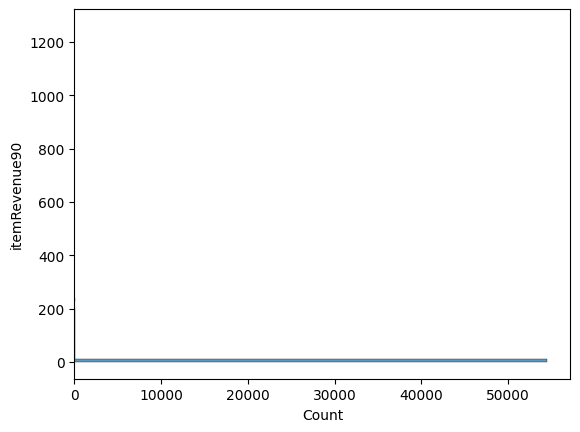

In [26]:
sns.histplot(data = country_filtered, y = 'itemRevenue90', bins = 100)

<Axes: ylabel='itemRevenue90'>

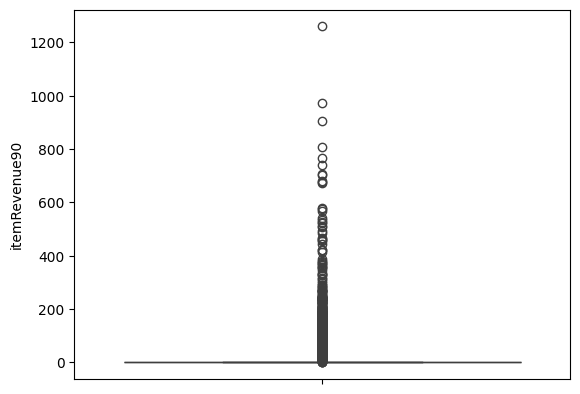

In [27]:
sns.boxplot(data = country_filtered, y = 'itemRevenue90')

<Axes: ylabel='itemRevenue90'>

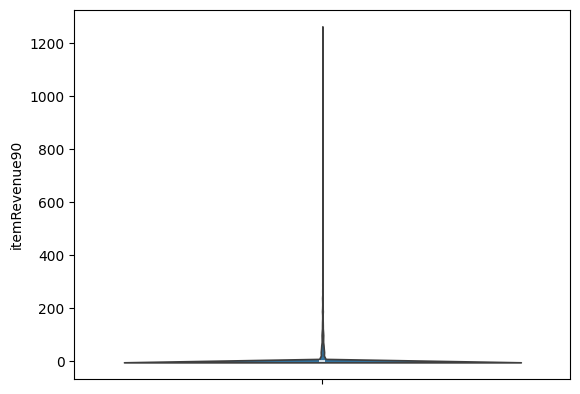

In [28]:
sns.violinplot(data = country_filtered, y = 'itemRevenue90')

In [29]:
df_bigger0 = country_filtered[country_filtered['itemRevenue90'] >1]


C:\Users\w11\AppData\Local\Temp\ipykernel_15120\1241503706.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data = df_bigger0, y = 'itemRevenue90', x = 'mobile_brand_name', palette = 'pastel')


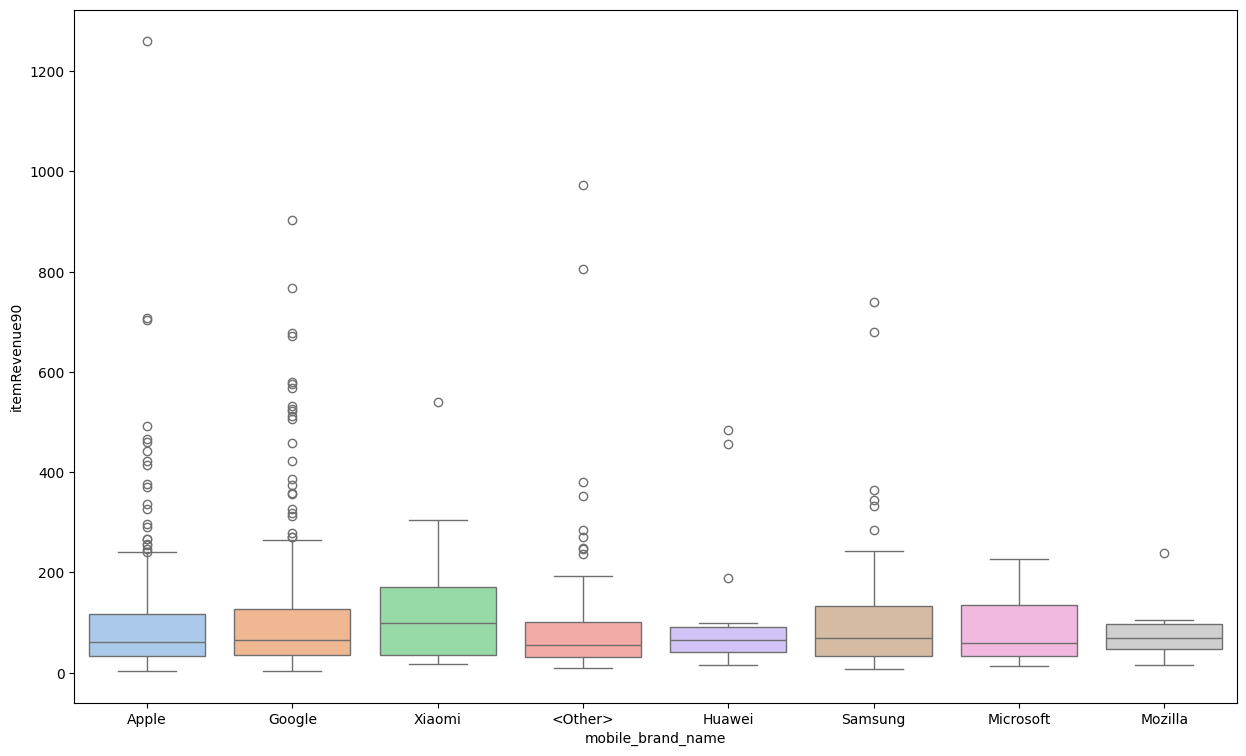

In [30]:
country_filtered_bigger00 = df_bigger0[df_bigger0['country'].isin(["United States", "Canada", "Germany", "India", "France", "Taiwan",'Italy', "Japan","Spain", "China", "Singapore", "South Korea", "Netherlands", 'Turkey'])]
plt.figure(figsize = (15,9))
sns.boxplot(data = df_bigger0, y = 'itemRevenue90', x = 'mobile_brand_name', palette = 'pastel')
plt.show()

C:\Users\w11\AppData\Local\Temp\ipykernel_15120\2470828620.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data = df_bigger0, y = 'itemRevenue90', x = 'category', palette = 'pastel')


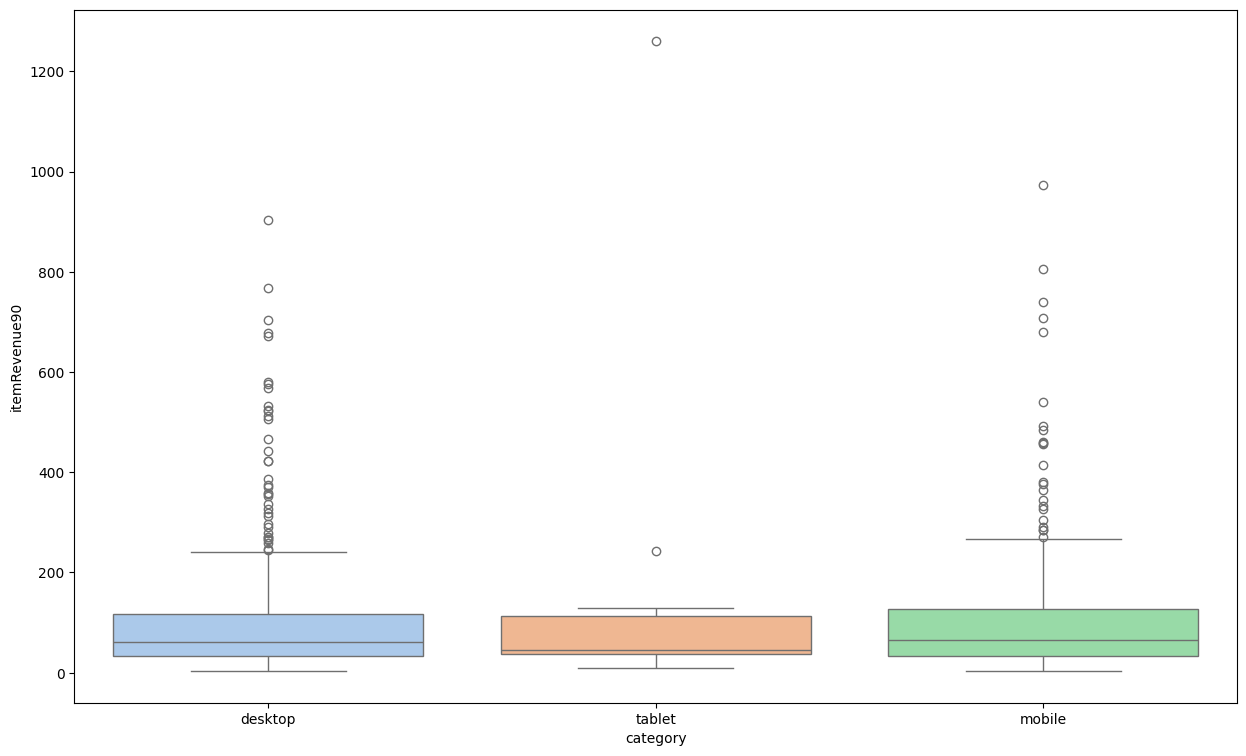

In [31]:

plt.figure(figsize = (15,9))
sns.boxplot(data = df_bigger0, y = 'itemRevenue90', x = 'category', palette = 'pastel')
plt.show()

C:\Users\w11\AppData\Local\Temp\ipykernel_15120\2514704441.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data = df_bigger0, y = 'itemRevenue90', x = 'country', palette = 'pastel')


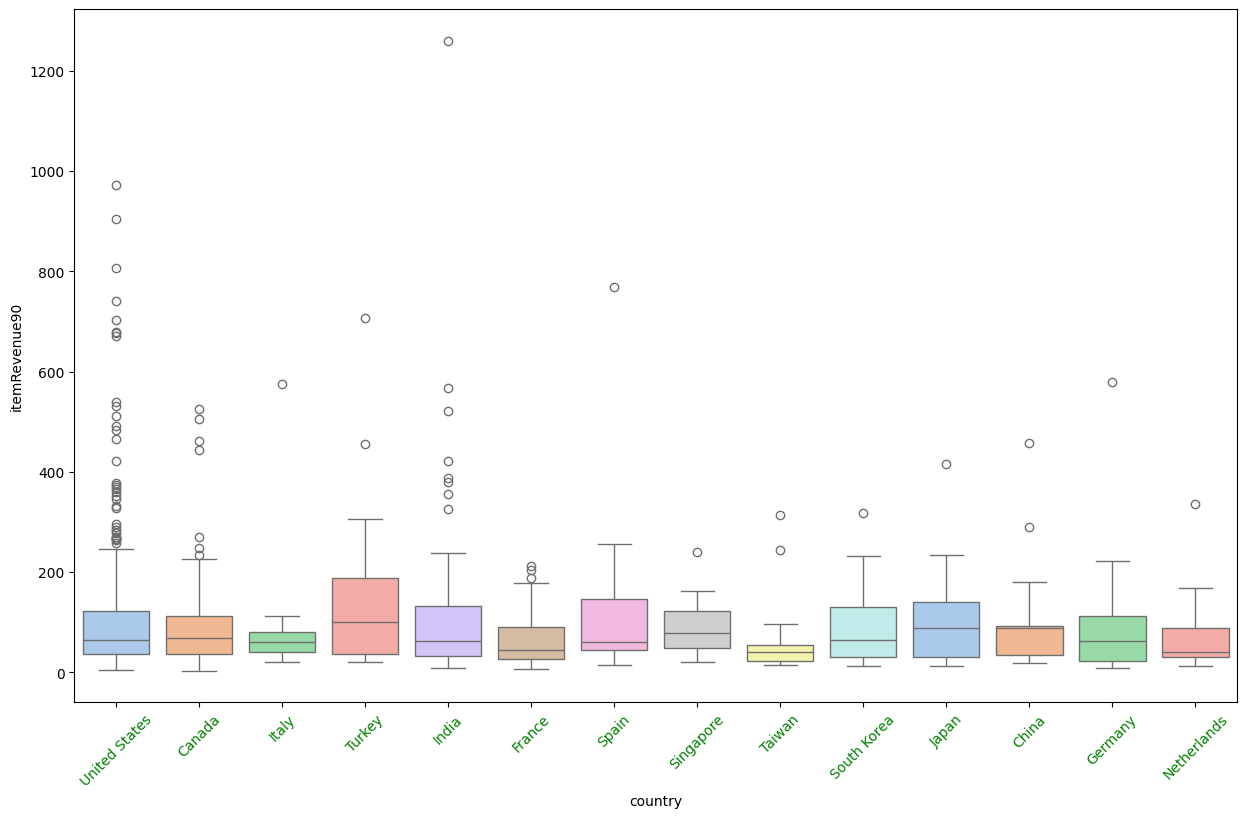

In [32]:
plt.figure(figsize = (15,9))
sns.boxplot(data = df_bigger0, y = 'itemRevenue90', x = 'country', palette = 'pastel')
plt.xticks(rotation = 45, color = 'g')
plt.show()

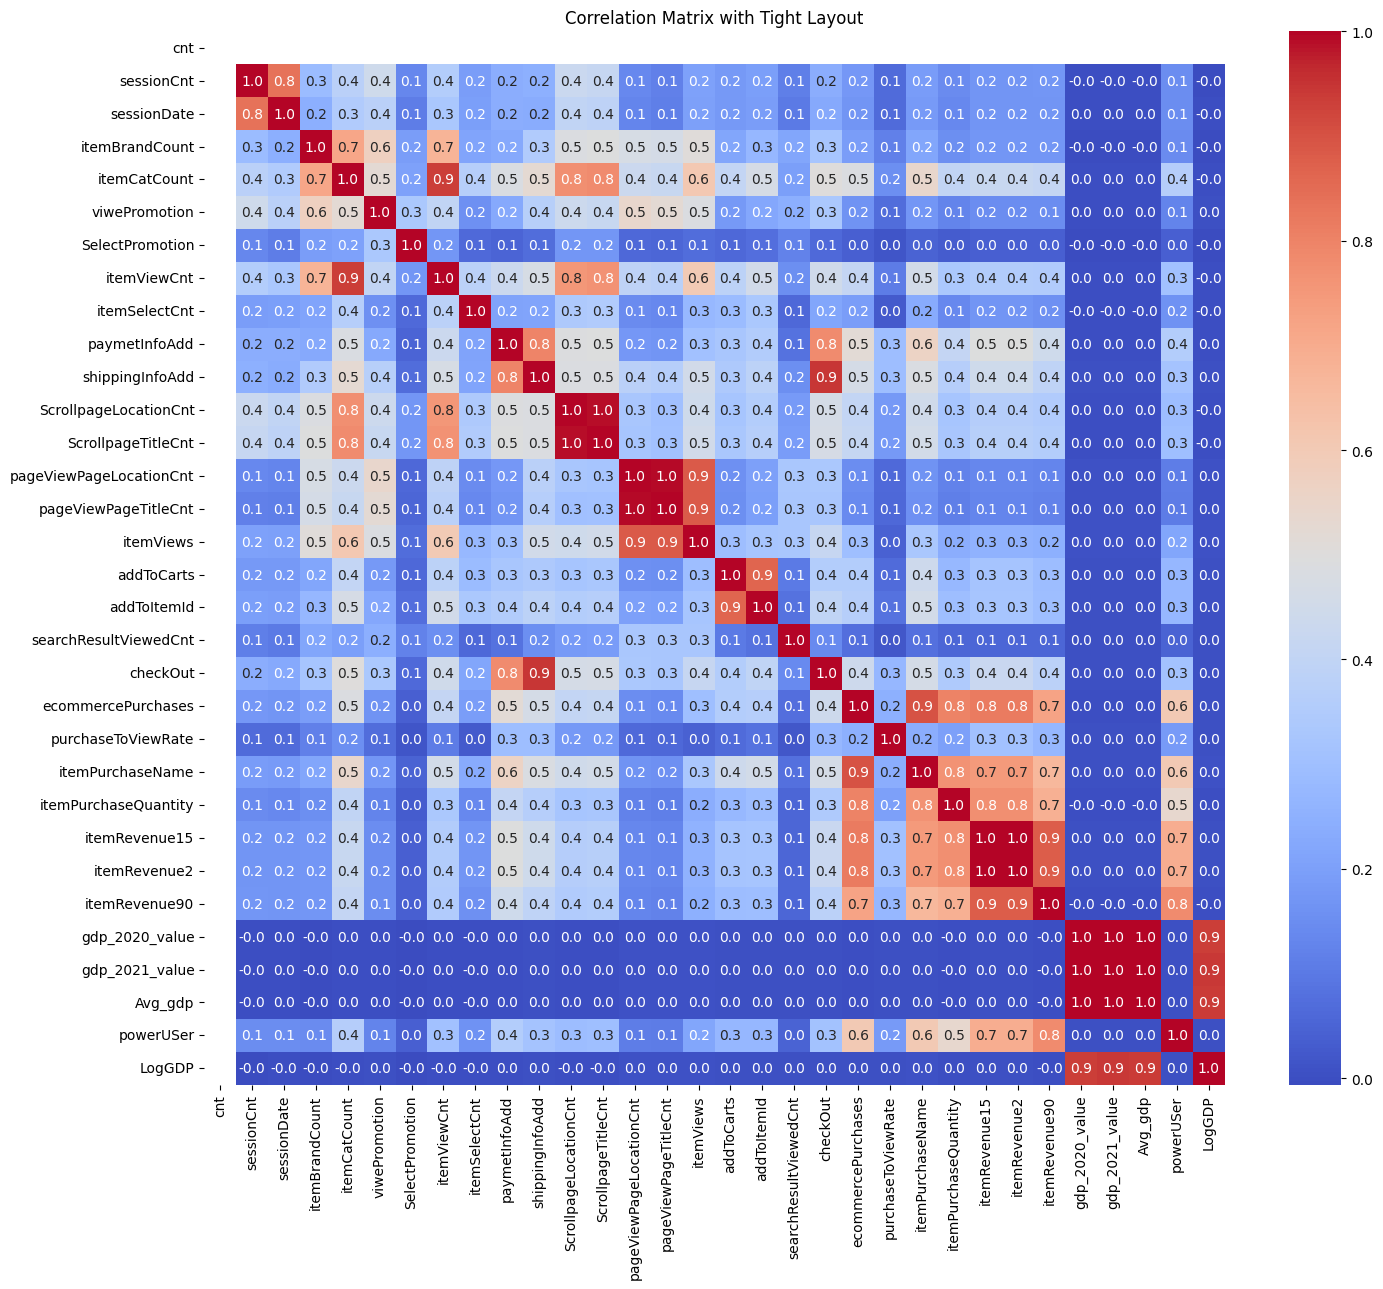

In [33]:
plt.figure(figsize = (15,13))
merged_num = country_filtered.select_dtypes(include = 'number')
sns.heatmap(merged_num.corr(), annot = True, fmt = ".1f", cmap = 'coolwarm')
plt.title('Correlation Matrix with Tight Layout')
plt.tight_layout()  # Apply tight layout to ensure proper display of annotations
plt.show()

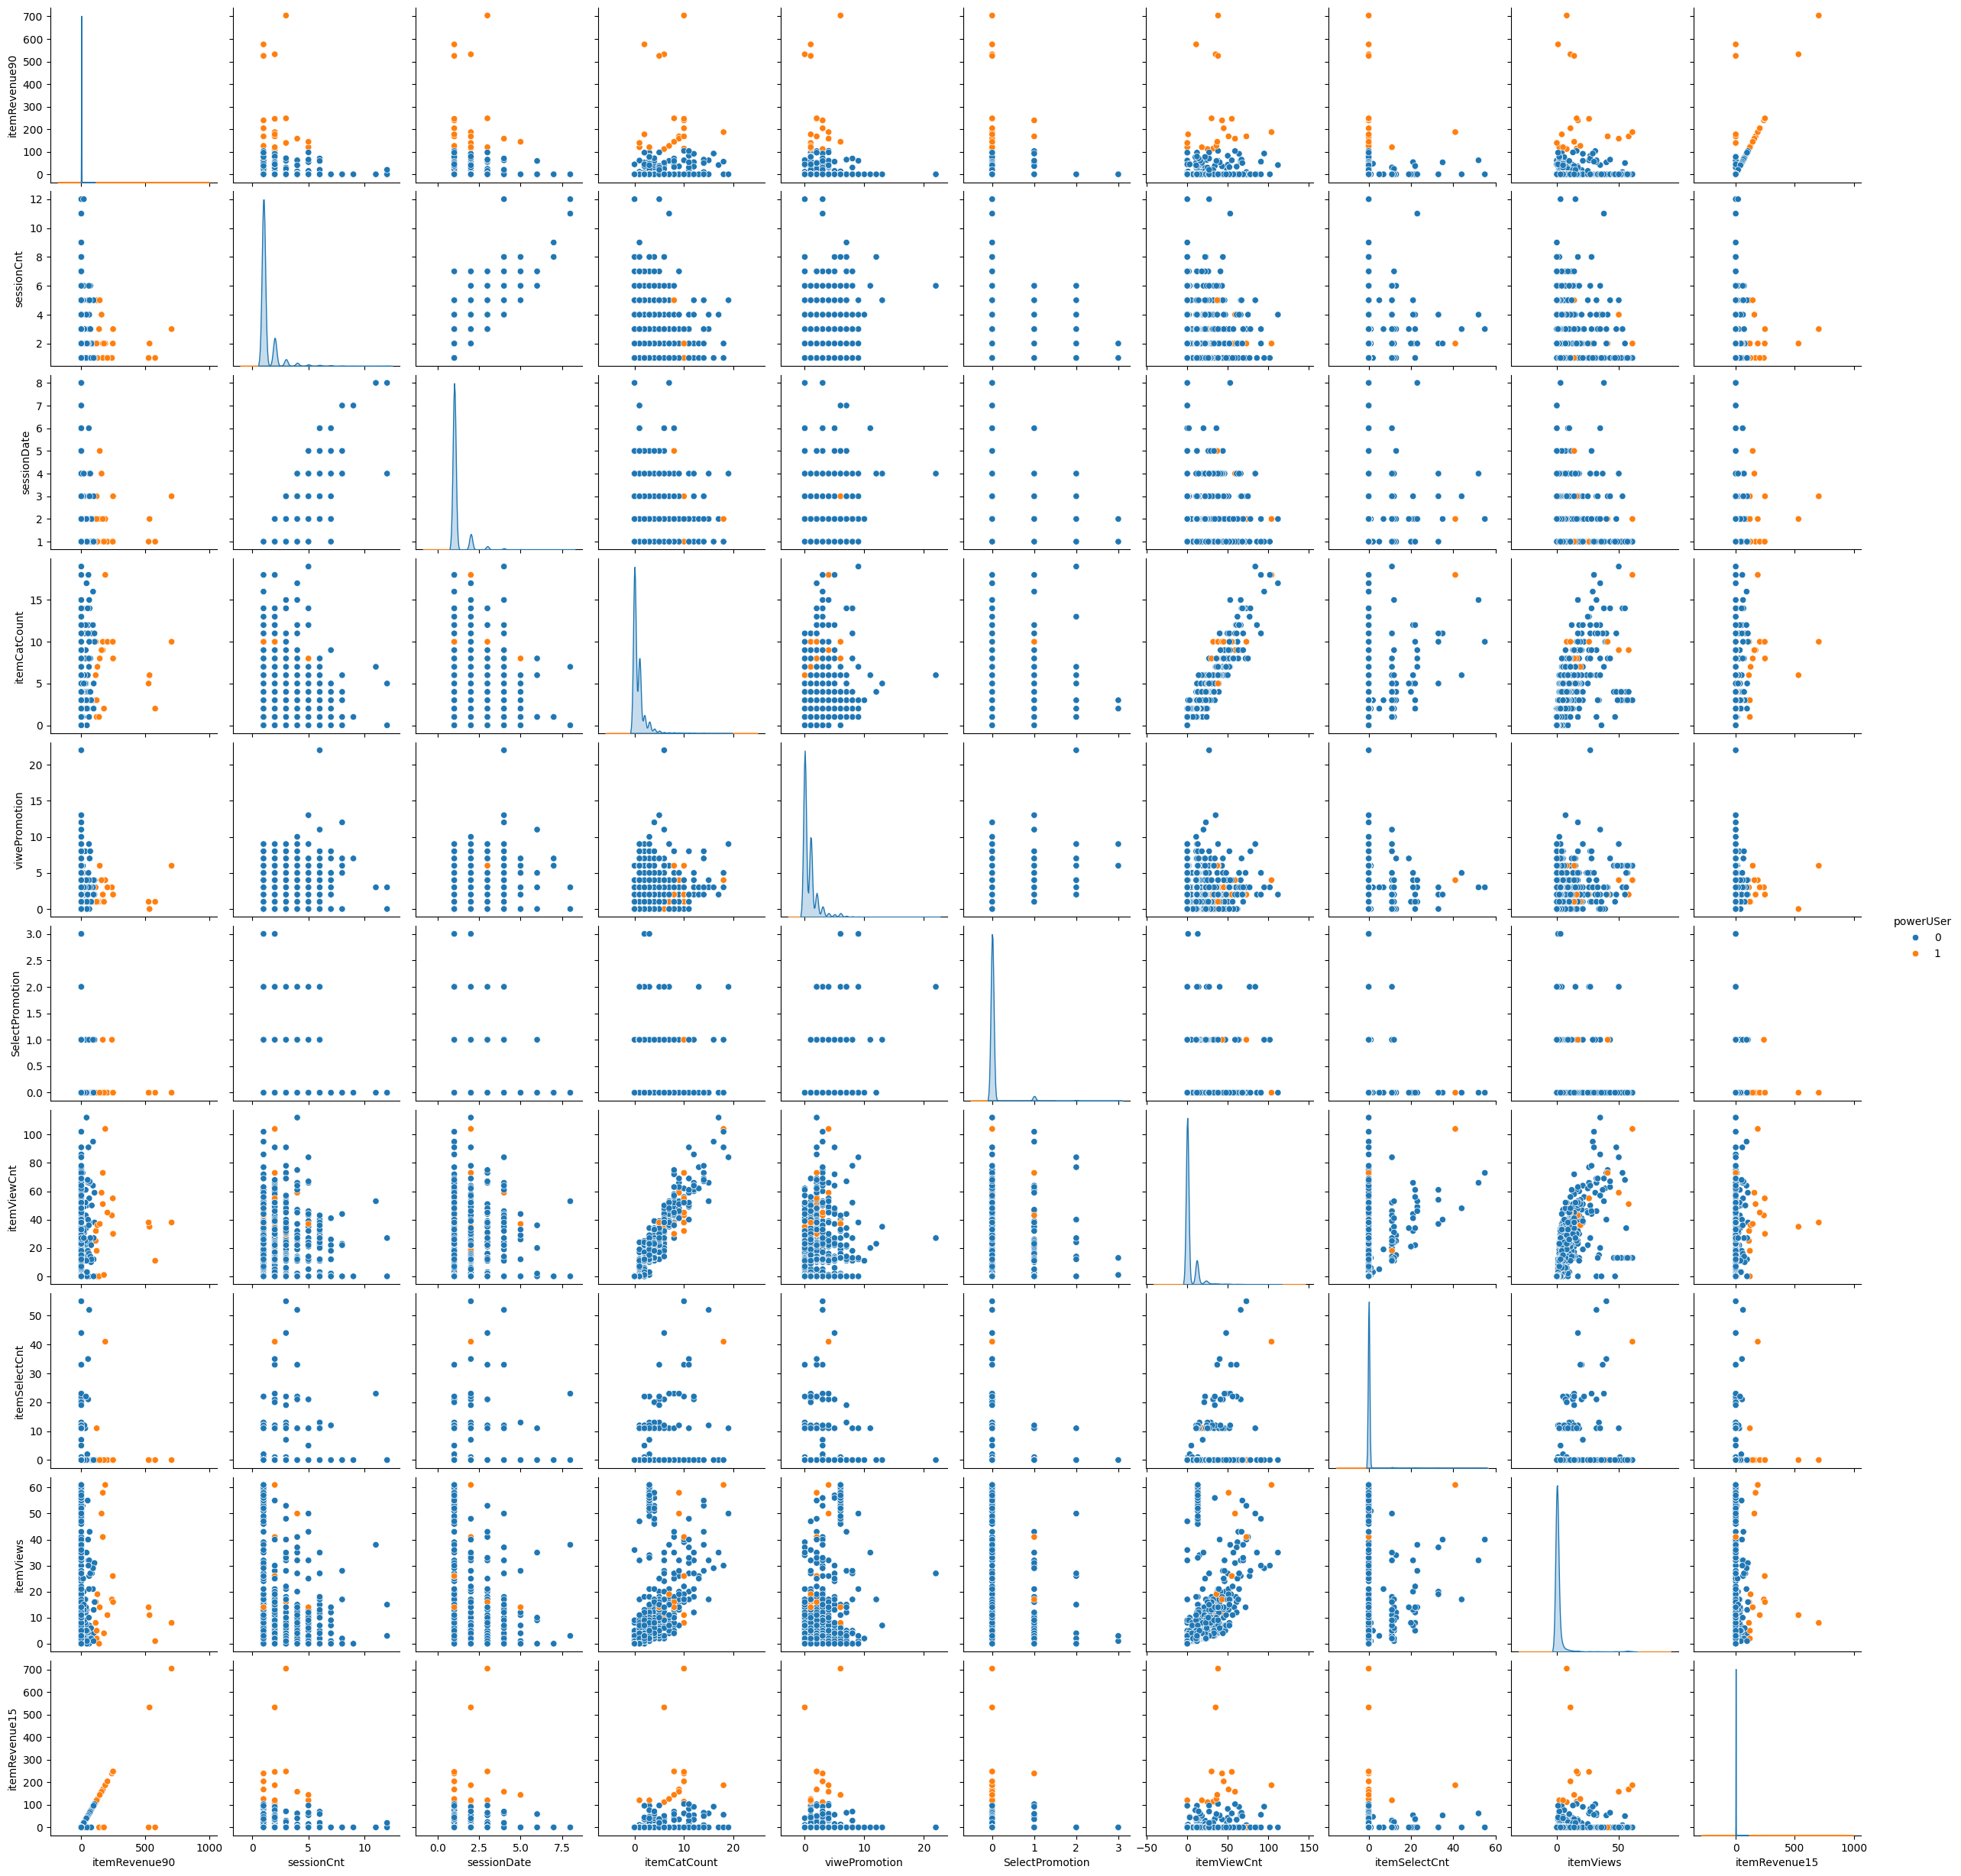

In [34]:
short = country_filtered[['itemRevenue90','sessionCnt','sessionDate','itemCatCount','viwePromotion','SelectPromotion','itemViewCnt','itemSelectCnt','itemViews','itemRevenue15','powerUSer']]
sns.pairplot(short.iloc[:6000], hue = 'powerUSer')


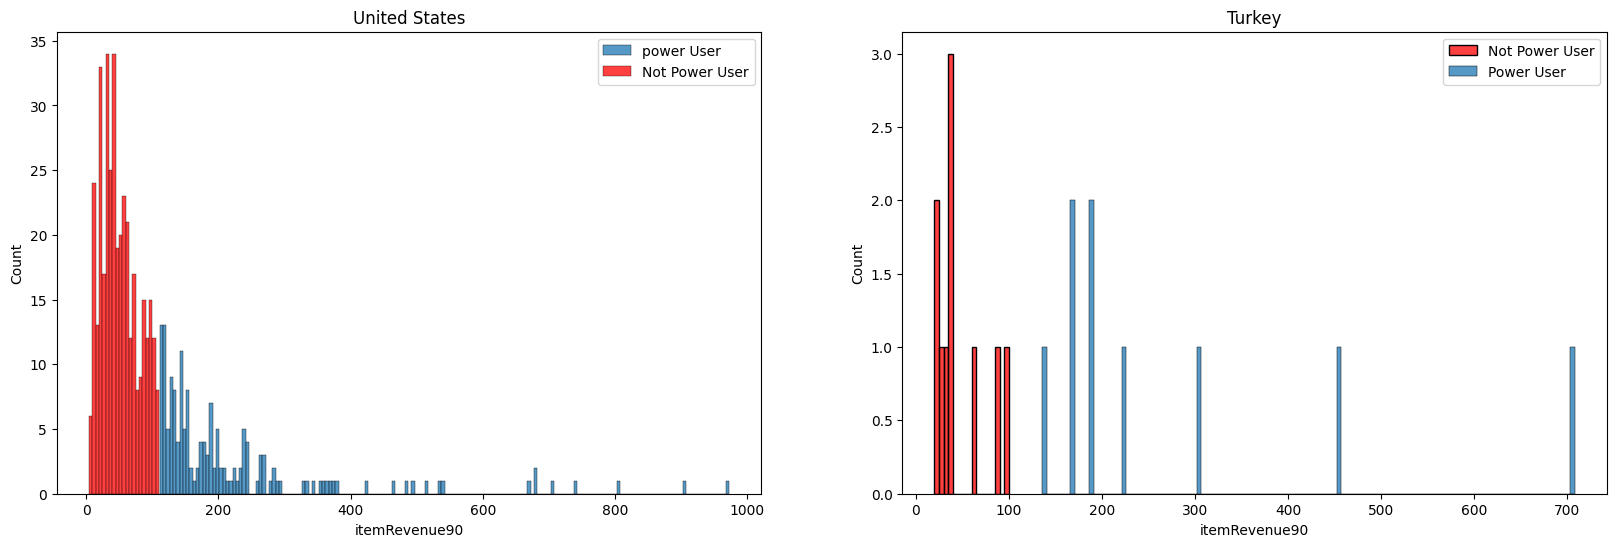

In [35]:
biger0_cf = country_filtered[country_filtered['itemRevenue90'] >0]
US = biger0_cf[biger0_cf['country']=='United States']
TR = biger0_cf[biger0_cf['country']=='Turkey']
plt.figure(figsize=[20,6])

plt.subplot(1,2,1)
sns.histplot(US[US['powerUSer']==1].itemRevenue90.dropna(), binwidth=5, label='power User')
sns.histplot(US[US['powerUSer']==0].itemRevenue90.dropna(), binwidth=5, label='Not Power User', color='red')

plt.legend()
plt.title('United States')

plt.subplot(1,2,2)
sns.histplot(TR[TR['powerUSer']==0].itemRevenue90.dropna(), binwidth=5, label='Not Power User', color='red')
sns.histplot(TR[TR['powerUSer']==1].itemRevenue90.dropna(), binwidth=5, label='Power User')

plt.legend()
plt.title('Turkey');

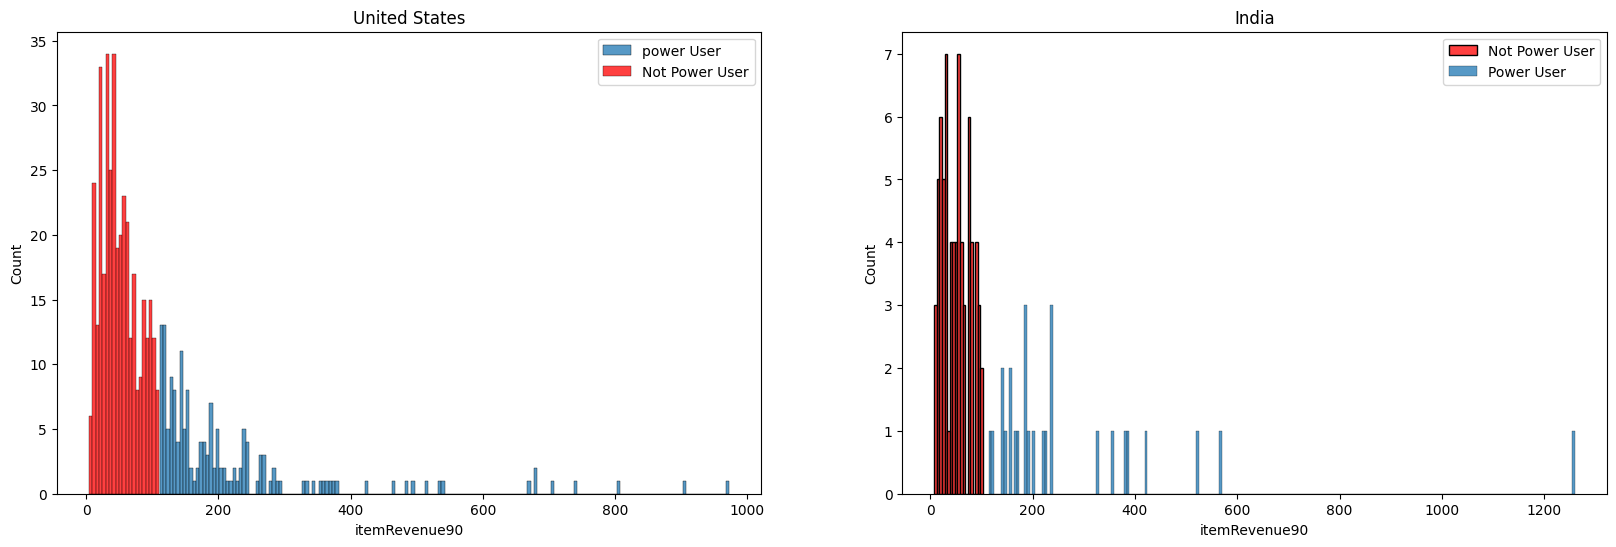

In [36]:
biger0_cf = country_filtered[country_filtered['itemRevenue90'] >0]
US = biger0_cf[biger0_cf['country']=='United States']
IN = biger0_cf[biger0_cf['country']=='India']
plt.figure(figsize=[20,6])

plt.subplot(1,2,1)
sns.histplot(US[US['powerUSer']==1].itemRevenue90.dropna(), binwidth=5, label='power User')
sns.histplot(US[US['powerUSer']==0].itemRevenue90.dropna(), binwidth=5, label='Not Power User', color='red')

plt.legend()
plt.title('United States')

plt.subplot(1,2,2)
sns.histplot(IN[IN['powerUSer']==0].itemRevenue90.dropna(), binwidth=5, label='Not Power User', color='red')
sns.histplot(IN[IN['powerUSer']==1].itemRevenue90.dropna(), binwidth=5, label='Power User')

plt.legend()
plt.title('India');

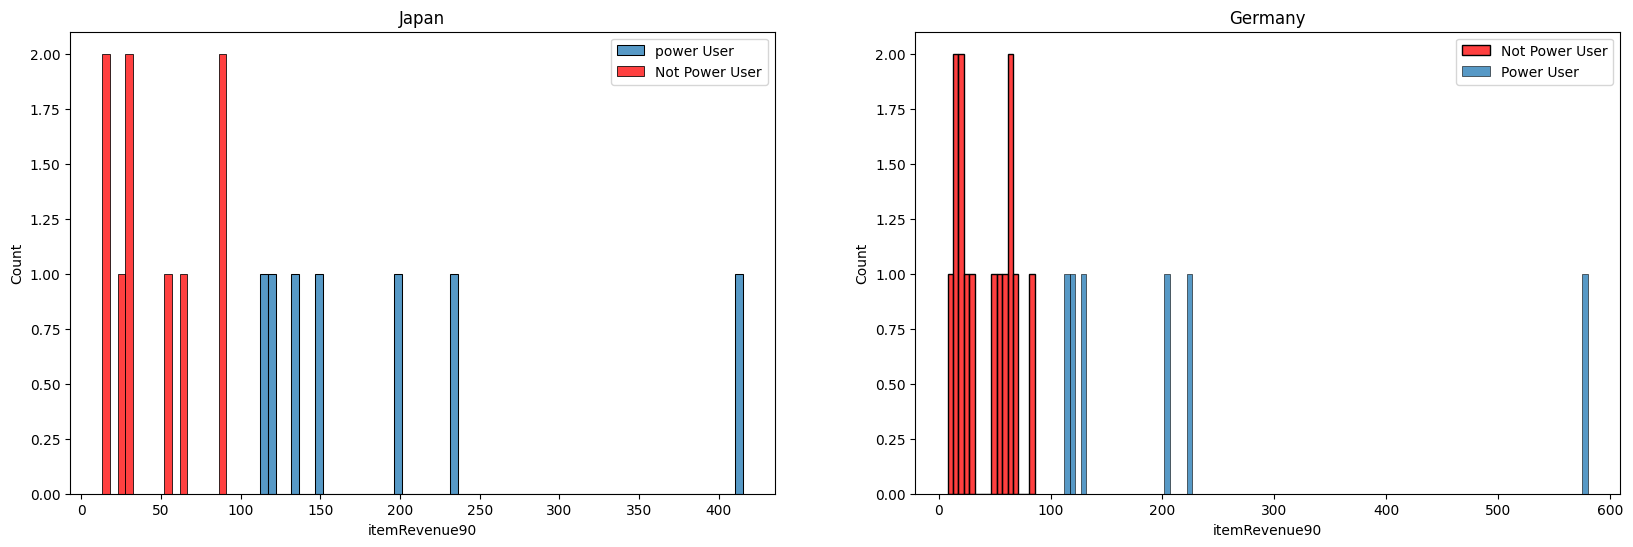

In [37]:
JP = biger0_cf[biger0_cf['country']=='Japan']
DE = biger0_cf[biger0_cf['country']=='Germany']
plt.figure(figsize=[20,6])

plt.subplot(1,2,1)
sns.histplot(JP[JP['powerUSer']==1].itemRevenue90.dropna(), binwidth=5, label='power User')
sns.histplot(JP[JP['powerUSer']==0].itemRevenue90.dropna(), binwidth=5, label='Not Power User', color='red')

plt.legend()
plt.title('Japan')

plt.subplot(1,2,2)
sns.histplot(DE[DE['powerUSer']==0].itemRevenue90.dropna(), binwidth=5, label='Not Power User', color='red')
sns.histplot(DE[DE['powerUSer']==1].itemRevenue90.dropna(), binwidth=5, label='Power User')

plt.legend()
plt.title('Germany');

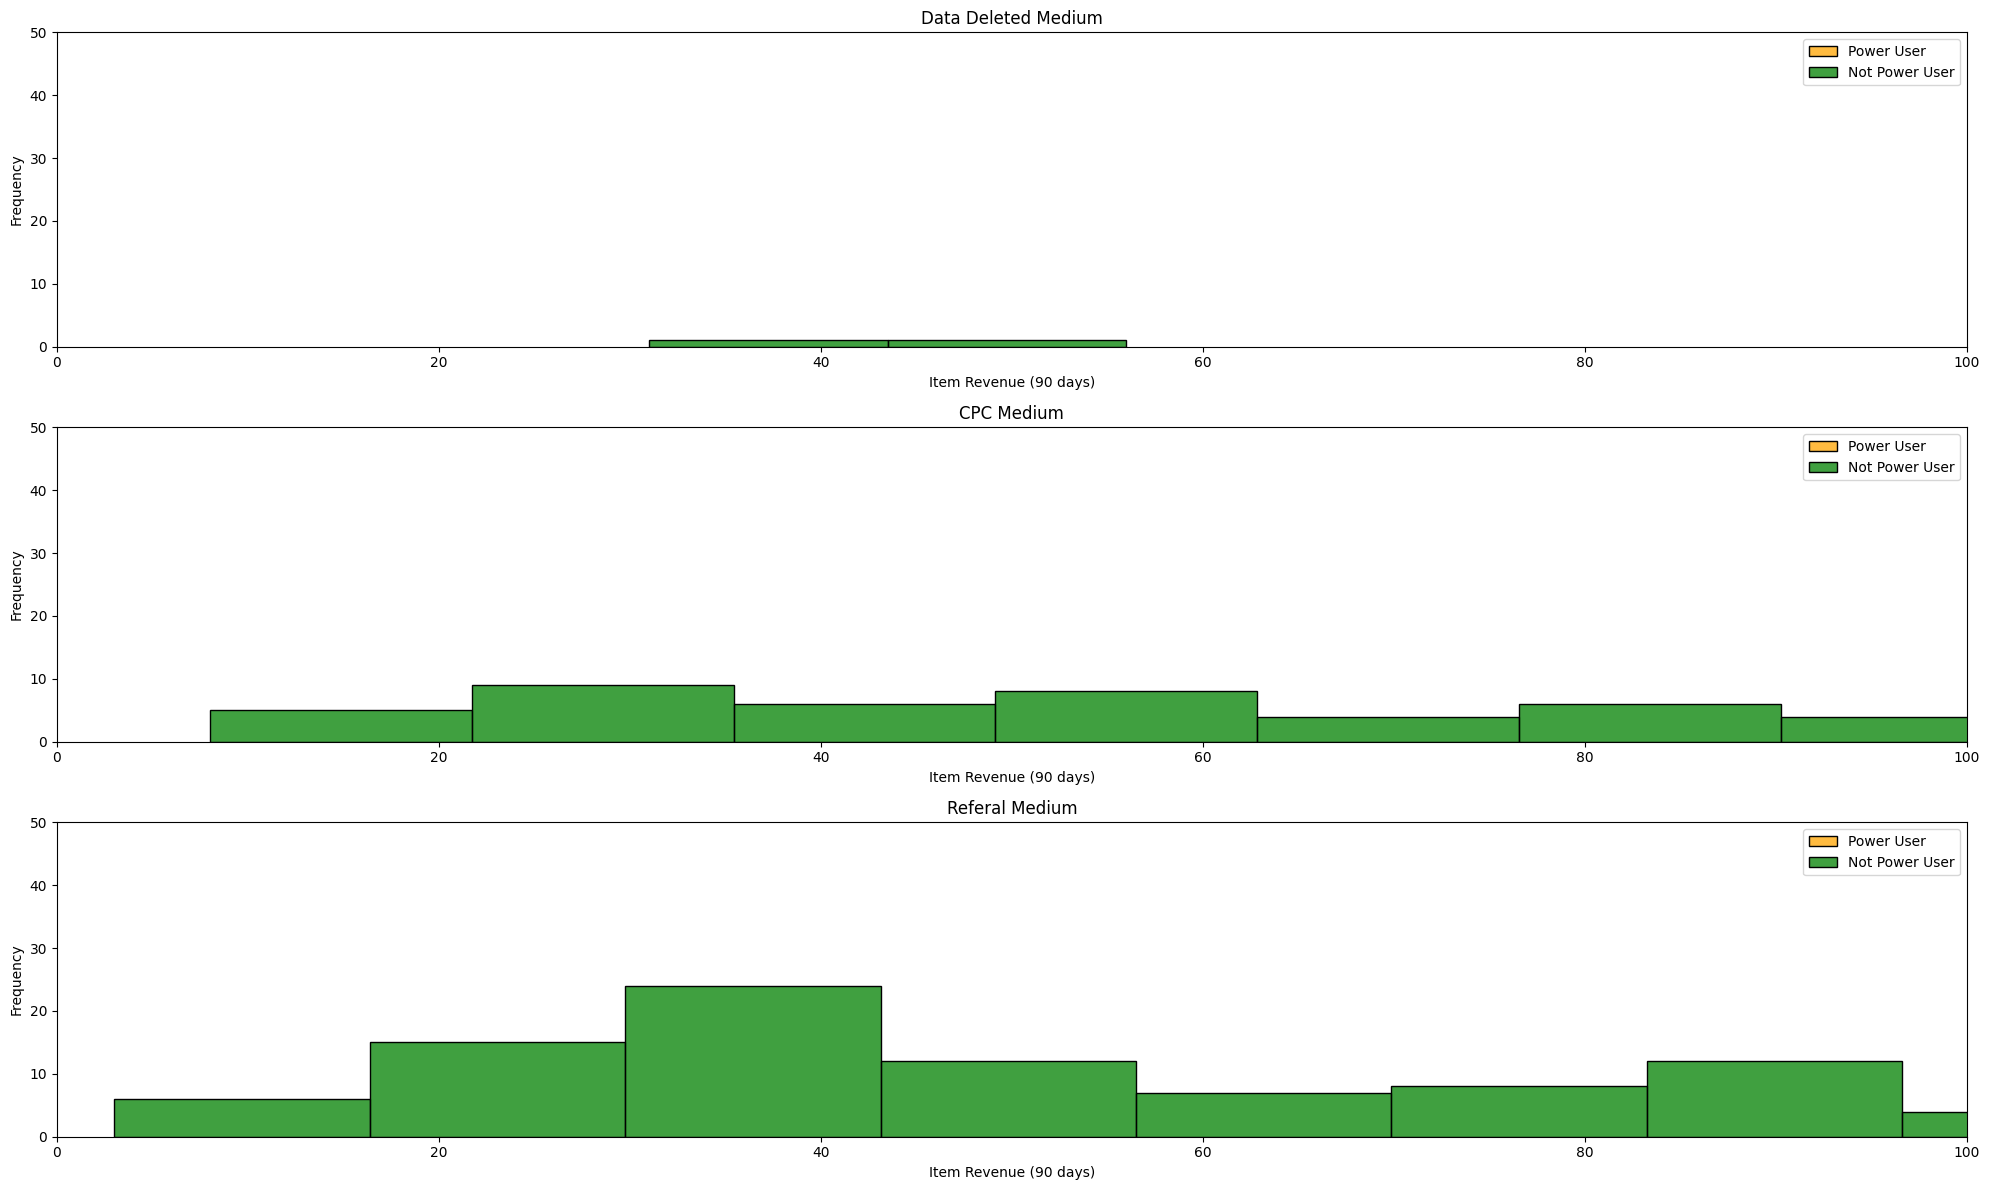

In [38]:
# Veri filtreleme
data_deleted = biger0_cf[biger0_cf['medium'] == '(data deleted)']
cpc = biger0_cf[biger0_cf['medium'] == 'cpc']
referal = biger0_cf[biger0_cf['medium'] == 'referral']

# Grafik boyutu
plt.figure(figsize=[20, 12])

# Birinci grafik: Data Deleted
plt.subplot(3, 1, 1)
sns.histplot(data_deleted[data_deleted['powerUSer'] == 1].itemRevenue90.dropna(), label='Power User', color='orange')
sns.histplot(data_deleted[data_deleted['powerUSer'] == 0].itemRevenue90.dropna(),  label='Not Power User', color='green')
plt.xlim(0, 100)
plt.ylim(0, 50)
plt.legend()
plt.title('Data Deleted Medium')
plt.xlabel('Item Revenue (90 days)')
plt.ylabel('Frequency')

# İkinci grafik: CPC
plt.subplot(3, 1, 2)
sns.histplot(cpc[cpc['powerUSer'] == 1].itemRevenue90.dropna(),  label='Power User', color='orange')
sns.histplot(cpc[cpc['powerUSer'] == 0].itemRevenue90.dropna(),  label='Not Power User', color='green')


plt.xlim(0, 100)
plt.ylim(0, 50)
plt.legend()
plt.title('CPC Medium')
plt.xlabel('Item Revenue (90 days)')
plt.ylabel('Frequency')

# Üçüncü grafik: Referal
plt.subplot(3, 1, 3)
sns.histplot(referal[referal['powerUSer'] == 1].itemRevenue90.dropna(),  label='Power User', color='orange')
sns.histplot(referal[referal['powerUSer'] == 0].itemRevenue90.dropna(),  label='Not Power User', color='green')
plt.xlim(0, 100)
plt.ylim(0, 50)
plt.legend()
plt.title('Referal Medium')
plt.xlabel('Item Revenue (90 days)')
plt.ylabel('Frequency')

# Düzeni sıkılaştırma
plt.tight_layout()
plt.show()


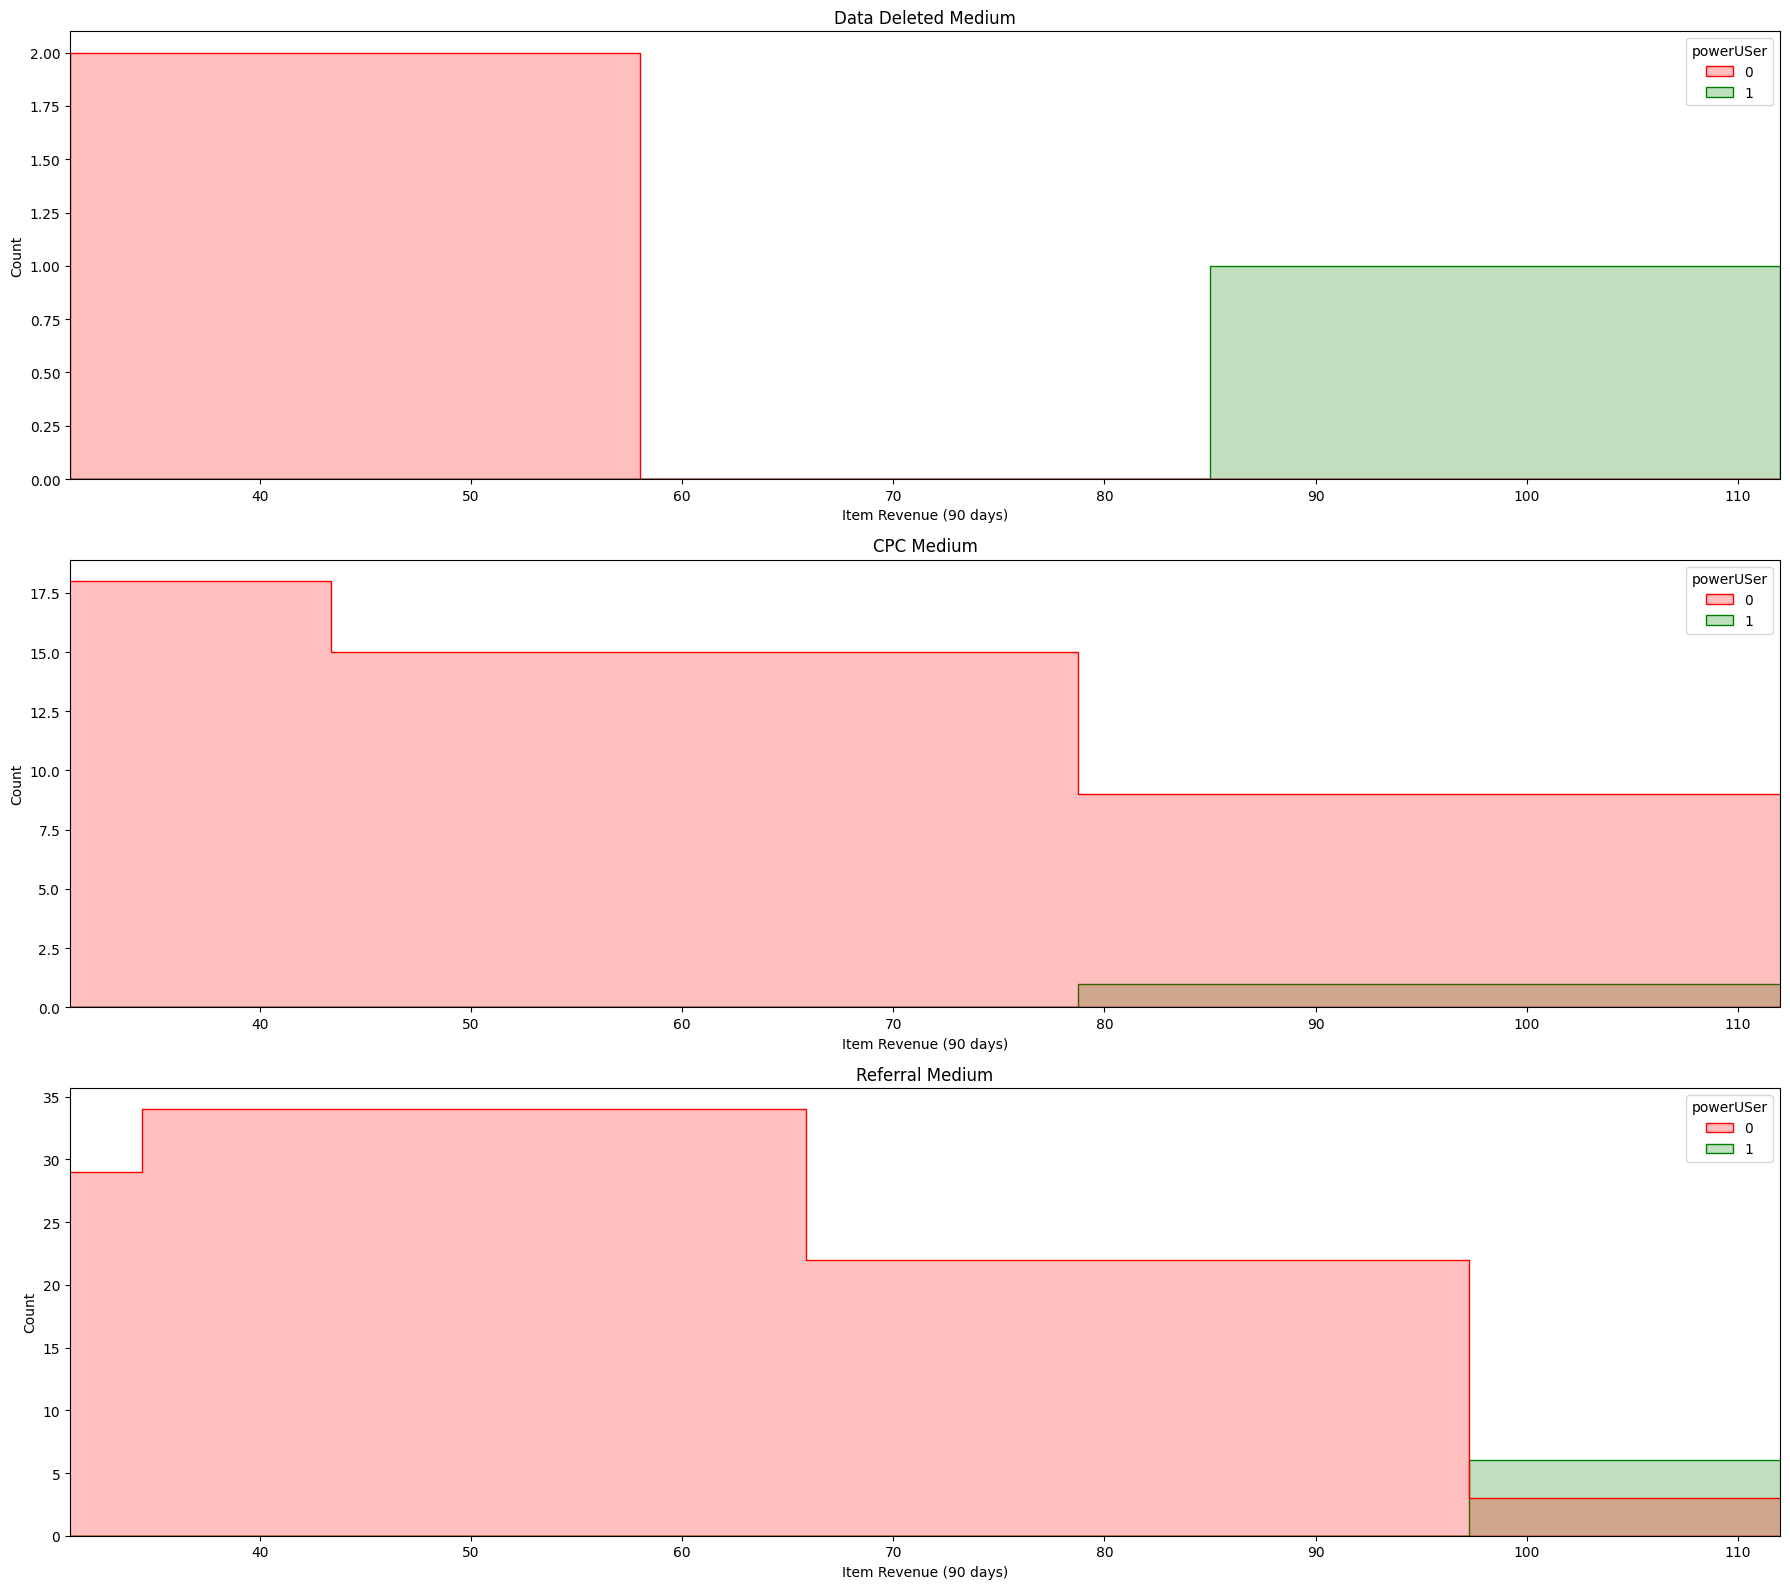

In [39]:
# X ekseni sınırlarını belirlemek için birinci grafiğin maksimum ve minimum değerlerini bulun
x_min = data_deleted['itemRevenue90'].min()
x_max = data_deleted['itemRevenue90'].max()

plt.figure(figsize=[18, 16])

# Birinci grafik: Data Deleted
plt.subplot(3, 1, 1)
sns.histplot(data=data_deleted, x='itemRevenue90', hue='powerUSer', element='step', palette={1: 'green', 0: 'red'})
plt.title('Data Deleted Medium')
plt.xlabel('Item Revenue (90 days)')
plt.ylabel('Count')
plt.xlim(x_min, x_max)  # X eksenini sabitle

# İkinci grafik: CPC
plt.subplot(3, 1, 2)
sns.histplot(data=cpc, x='itemRevenue90', hue='powerUSer', element='step', palette={1: 'green', 0: 'red'})
plt.title('CPC Medium')
plt.xlabel('Item Revenue (90 days)')
plt.ylabel('Count')
plt.xlim(x_min, x_max)  # X eksenini sabitle

# Üçüncü grafik: Referral
plt.subplot(3, 1, 3)
sns.histplot(data=referal, x='itemRevenue90', hue='powerUSer', element='step', palette={1: 'green', 0: 'red'})
plt.title('Referral Medium')
plt.xlabel('Item Revenue (90 days)')
plt.ylabel('Count')
plt.xlim(x_min, x_max)  # X eksenini sabitle

# Alt grafikler arasındaki düzeni sıkılaştır
plt.tight_layout()
plt.show()


c:\Users\w11\anaconda3\envs\deepLearning\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

  func(*plot_args, **plot_kwargs)
c:\Users\w11\anaconda3\envs\deepLearning\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

  func(*plot_args, **plot_kwargs)
c:\Users\w11\anaconda3\envs\deepLearning\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

  func(*plot_args, **plot_kwargs)


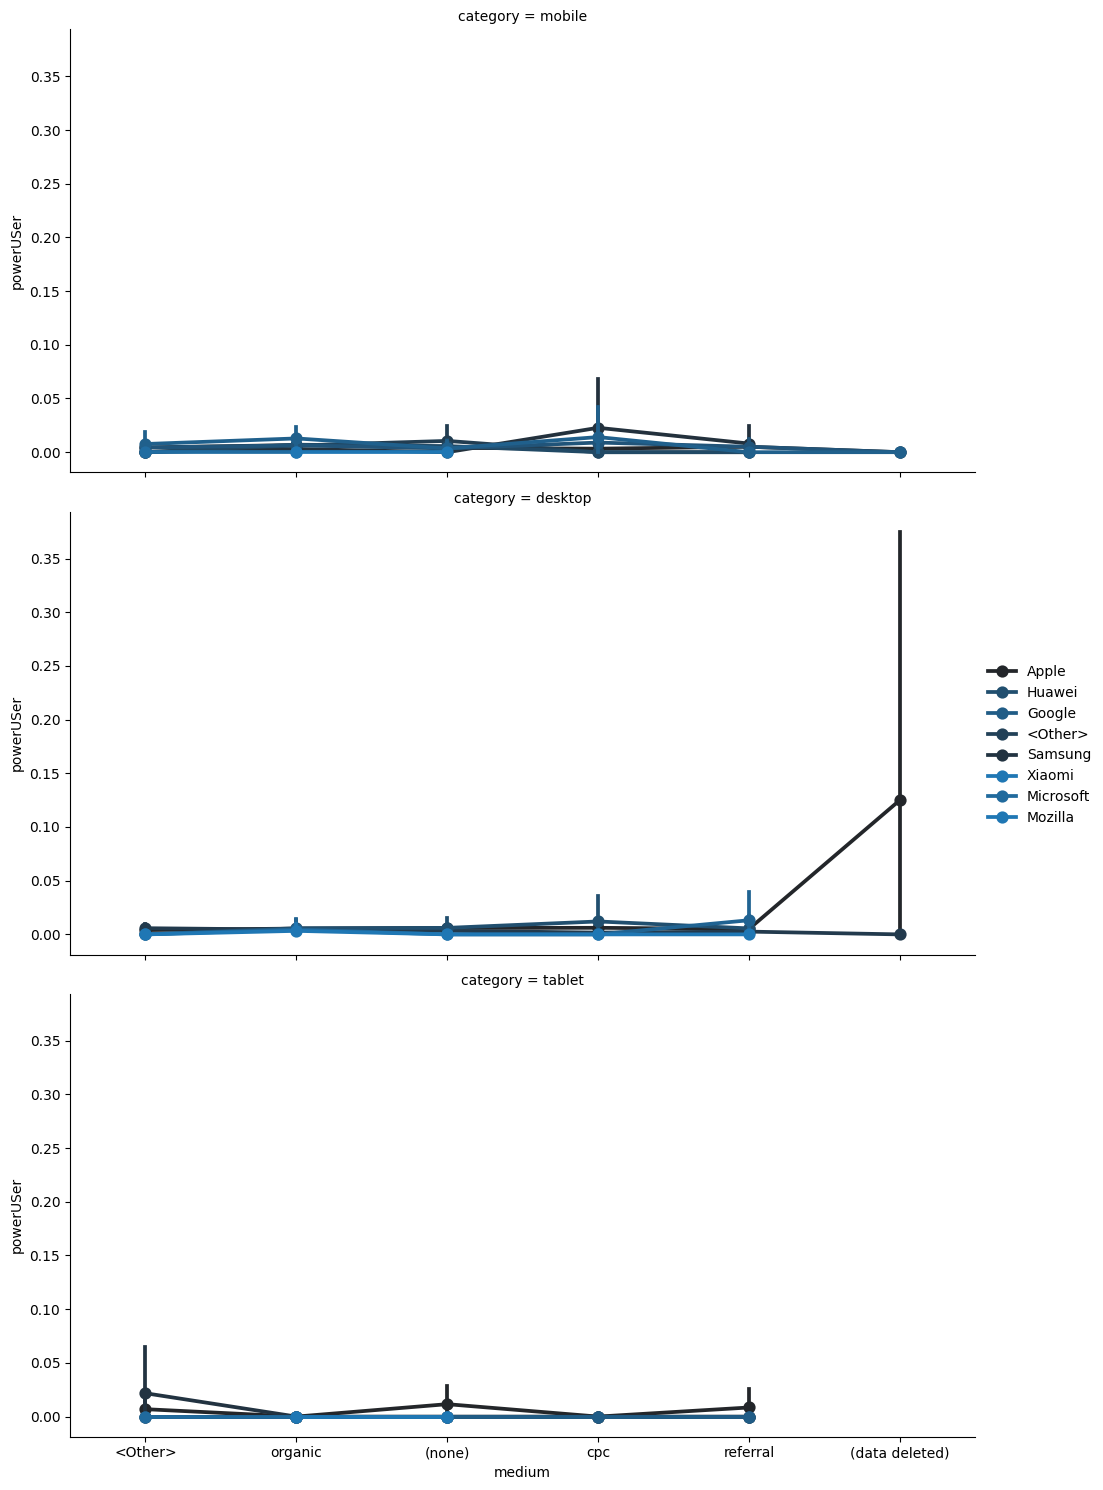

In [40]:
FacetGrid = sns.FacetGrid(country_filtered, row='category', height=5, aspect=2)
FacetGrid.map(sns.pointplot, 'medium', 'powerUSer', 'mobile_brand_name', order=None, hue_order=None)
FacetGrid.add_legend();

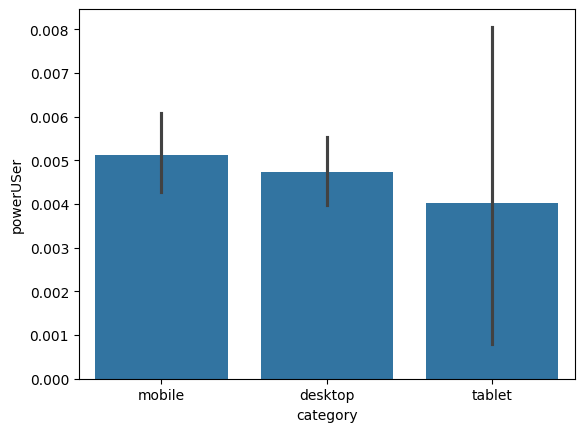

In [41]:
sns.barplot(x='category', y='powerUSer', data=country_filtered);


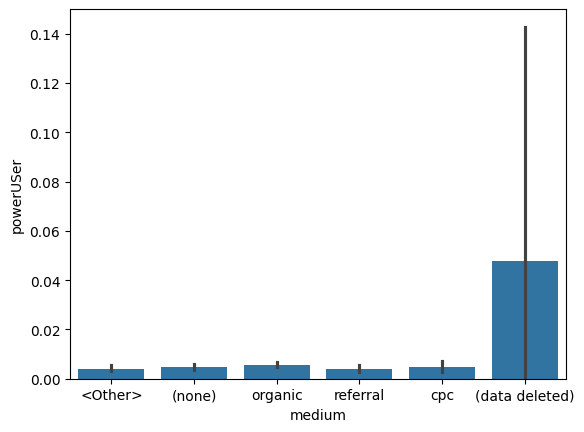

In [42]:
sns.barplot(x='medium', y='powerUSer', data=country_filtered);


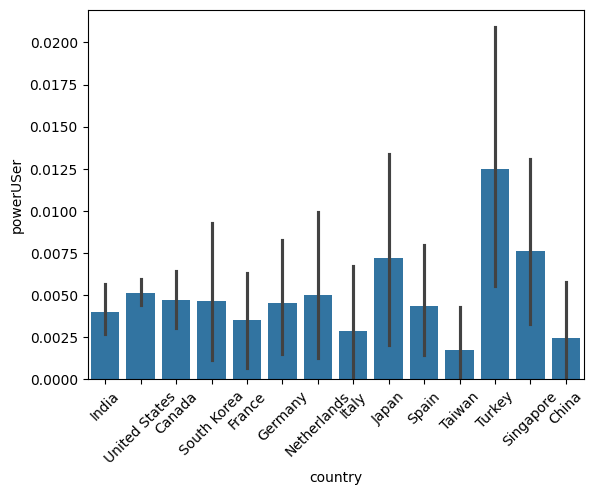

In [43]:
sns.barplot(x='country', y='powerUSer', data=country_filtered)
plt.xticks(rotation=45)
plt.show()


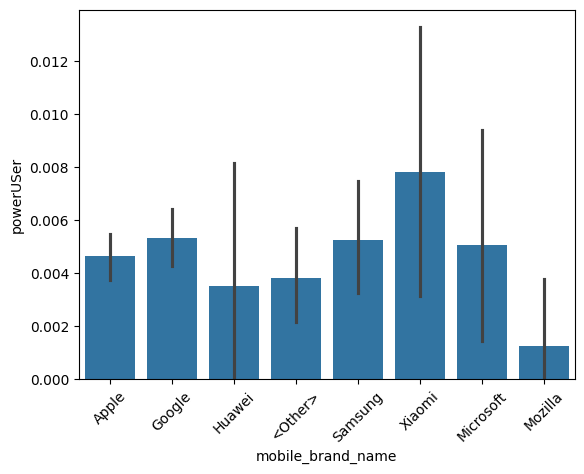

In [44]:
sns.barplot(x='mobile_brand_name', y='powerUSer', data=country_filtered);
plt.xticks(rotation=45)
plt.show()

In [45]:
x_train.shape

(38754, 55)

In [46]:
def knn_model_output(x_train, y_train, x_test, y_test):
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('knn', KNeighborsClassifier())
    ])
    
    # Parametre Izgarası
    param_grid = {
        'knn__n_neighbors': np.arange(1, 31, 2),  # Komşu sayısı için 1 ile 30 arasında tek sayılar
        'knn__weights': ['uniform', 'distance'],  # Ağırlıklandırma tipi
        'knn__metric': ['euclidean', 'manhattan', 'minkowski']  # Mesafe metriği
    }
    
    # GridSearchCV
    grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='recall', verbose=1, n_jobs=-1)
    
    # GridSearchCV Modelini Eğitme
    grid_search.fit(x_train, y_train)
    
    # En İyi Recall Skoru ve Parametreler
    print("Best Params:", grid_search.best_params_)
    print("Best Recall Score:", grid_search.best_score_)
    
    # En iyi parametrelerle tüm eğitim verisi üzerinde modeli yeniden eğitme
    best_params = grid_search.best_params_
    # Pipeline'ı en iyi bulunan parametrelerle güncelleme
    best_knn = Pipeline([
        ('scaler', StandardScaler()),
        ('knn', KNeighborsClassifier(n_neighbors=best_params['knn__n_neighbors'],
                                     weights=best_params['knn__weights'],
                                     metric=best_params['knn__metric']))
    ])
    best_knn.fit(x_train, y_train)
    
    # En iyi modeli kullanarak test verisi üzerinde tahmin yapma
    y_pred_knn_best = best_knn.predict(x_test)
    y_prob_knn_best = best_knn.predict_proba(x_test)
    
    # Metrikleri Hesaplama
    recall_knn_best = recall_score(y_test, y_pred_knn_best)
    precision_knn_best = precision_score(y_test, y_pred_knn_best)
    accuracy_knn_best = accuracy_score(y_test, y_pred_knn_best)
    logLoss_knn_best = log_loss(y_test, y_prob_knn_best)
    
    # Sonuçları Yazdırma
    print(f'KNN Best Model Recall: {recall_knn_best}')
    print(f'KNN Best Model Precision: {precision_knn_best}')
    print(f'KNN Best Model Accuracy: {accuracy_knn_best}')
    print(f'KNN Best Model Log Loss: {logLoss_knn_best}')
    
    # Confusion Matrix Görselleştirme
    cm = confusion_matrix(y_test, y_pred_knn_best)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap='coolwarm',
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix for KNN Model')
    plt.show()


In [47]:
def xgb_model_output(x_train, y_train, x_test, y_test):
    param_grid = {
        'n_estimators': [50, 100, 150],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'gamma': [0, 0.1, 0.2],
        'reg_alpha': [0, 0.1],
        'reg_lambda': [1, 2]
    }
    
    xgb = XGBClassifier( eval_metric='logloss')
    grid_search = GridSearchCV(xgb, param_grid, cv=5, scoring='recall', verbose=1)
    
    # Fit GridSearchCV Model
    grid_search.fit(x_train, y_train)
    
    # Best Recall Score and Parameters
    print("Best Params:", grid_search.best_params_)
    print("Best Recall Score:", grid_search.best_score_)
    
    # Retrain model with best parameters on the entire training data
    best_params = grid_search.best_params_
    xgb_best = XGBClassifier(**best_params, use_label_encoder=False, eval_metric='logloss')
    xgb_best.fit(x_train, y_train)
    
    
    # Predict for test using the best model
    y_pred_xgb_best = xgb_best.predict(x_test)
    y_prob_xgb_best = xgb_best.predict_proba(x_test)
    recall_xgb_best = recall_score(y_test, y_pred_xgb_best)
    LogLoss_xgb_best = log_loss(y_test, y_prob_xgb_best)
    print(f'XGB Best Model Recall: {recall_xgb_best}')
    print(f'XGB Log Loss: {LogLoss_xgb_best}')
    print('XGB Confusion Matrix: \n\n', confusion_matrix(y_test, y_pred_xgb_best))
    
    # Displaying Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_xgb_best)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap='coolwarm', xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

In [48]:
def logistic_regression_model_output(x_train, y_train, x_test, y_test):
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('logistic', LogisticRegression())
    ])
    
    param_grid = [
        {
            'logistic__solver': ['liblinear', 'saga'],
            'logistic__penalty': ['l1'],
            'logistic__C': [0.001, 0.01, 0.1, 1, 10, 100],
            'logistic__max_iter': [100, 500, 1000]
        },
        {
            'logistic__solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'],
            'logistic__penalty': ['l2'],
            'logistic__C': [0.001, 0.01, 0.1, 1, 10, 100],
            'logistic__max_iter': [100, 500, 1000]
        },
        {
            'logistic__solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
            'logistic__penalty': ['None'],
            'logistic__max_iter': [100, 500, 1000]
        }
    ]
    
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='recall', verbose=1, n_jobs=-1)
    grid_search.fit(x_train, y_train)
    
    print("Best Params:", grid_search.best_params_)
    print("Best Recall Score:", grid_search.best_score_)
    
    logistic_best = grid_search.best_estimator_
    y_pred_logistic_best = logistic_best.predict(x_test)
    y_prob_logistic_best = logistic_best.predict_proba(x_test)
    recall_logistic_best = recall_score(y_test, y_pred_logistic_best)
    LogLoss_logistic_best = log_loss(y_test, y_prob_logistic_best)
    print(f'Logistic Regression Best Model Recall: {recall_logistic_best}')
    print(f'Logistic Regression Best Model Log Loss: {LogLoss_logistic_best}')
    
    cm = confusion_matrix(y_test, y_pred_logistic_best)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Greens',
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix for Logistic Regression')
    plt.show()


In [49]:
def rf_model_output(x_train, y_train, x_test, y_test):
    
    param_grid = {
        'n_estimators': [10, 50, 100, 200],
        'max_features': ['sqrt', 'log2'],  # 'auto' kaldırıldı
        'max_depth': [None, 10, 20, 30, 40],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False]
    }
    
    rf = RandomForestClassifier()
    grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='recall', verbose=1, n_jobs=-1)
    
    
    grid_search.fit(x_train, y_train)
    
    
    print("Best Params:", grid_search.best_params_)
    print("Best Recall Score:", grid_search.best_score_)
    
    
    best_params = grid_search.best_params_
    rf_best = RandomForestClassifier(**best_params)
    rf_best.fit(x_train, y_train)
    
    y_pred_rf_best = rf_best.predict(x_test)
    y_prob_rf_best = rf_best.predict_proba(x_test)
    recall_rf_best = recall_score(y_test, y_pred_rf_best)
    LogLoss_rf_best = log_loss(y_test, y_prob_rf_best)
    print(f'Random Forest Best Model Recall: {recall_rf_best}')
    print(f'Random Forest Log Loss: {LogLoss_rf_best}')
    
    cm = confusion_matrix(y_test, y_pred_rf_best)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap='coolwarm',
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix for Random Forest')
    plt.show()


In [50]:
def svm_model_output(x_train, y_train, x_test, y_test):
    # Param Grid's
    param_grid = {
        'C': [0.1, 1, 10],               
        'kernel': ['linear', 'rbf', 'poly'],  
        'gamma': ['scale', 'auto', 0.01, 0.1, 1], 
        'degree': [2, 3, 4]                   
    }
    
    svm = SVC()
    grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='recall', verbose=1)
    
    # Fit GridSearchCV Model
    grid_search.fit(x_train, y_train)
    
    # Best Recall Score and Parameters
    print("Best Params:", grid_search.best_params_)
    print("Best Recall Score:", grid_search.best_score_)
    
    # Retrain model with best parameters on the entire training data
    best_params = grid_search.best_params_
    svm_best = SVC(**best_params)
    svm_best.fit(x_train, y_train)
    
    # Predict for test using the best model
    y_pred_svm_best = svm_best.predict(x_test)
    y_prob_svm_best = svm_best.predict_proba(x_test)
    recall_svm_best = recall_score(y_test, y_pred_svm_best)
    print(f'SVM Best Model Recall: {recall_svm_best}')
    print(f'SVM Best Log Loss : {y_prob_svm_best}')
    print('SVM Confusion Matrix: \n\n', confusion_matrix(y_test, y_pred_svm_best))
    
    # Displaying Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_svm_best)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap='coolwarm', xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

In [51]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import recall_score, log_loss, confusion_matrix
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

class RecallCallback(Callback):
    def __init__(self, validation_data):
        self.validation_data = validation_data

    def on_epoch_end(self, epoch, logs=None):
        val_x, val_y = self.validation_data
        val_pred = (self.model.predict(val_x) > 0.5).astype(int).flatten()
        val_recall = recall_score(val_y, val_pred)
        logs['val_recall'] = val_recall
        print(f" - val_recall: {val_recall:.4f}")

def create_model(input_dim, optimizer='adam', activation='relu', neurons=32, dropout_rate=0.0):
    
    model = Sequential()
    model.add(Dense(neurons, input_dim=input_dim, activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons, activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))  # Binary sınıflandırma için sigmoid aktivasyon

    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

def keras_model_output(x_train, y_train, x_test, y_test):
    
    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(x_train)
    x_test_scaled = scaler.transform(x_test)

    input_dim = x_train.shape[1]
    model = create_model(input_dim=input_dim, optimizer='adam', activation='relu', neurons=32, dropout_rate=0.0)

    
    recall_callback = RecallCallback(validation_data=(x_test_scaled, y_test))

    # EarlyStopping Callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    
    history = model.fit(
        x_train_scaled,
        y_train,
        validation_data=(x_test_scaled, y_test),
        epochs=100,
        batch_size=32,
        callbacks=[recall_callback, early_stopping],
        verbose=1
    )

    y_pred_prob = model.predict(x_test_scaled)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()

    recall = recall_score(y_test, y_pred)
    logloss = log_loss(y_test, np.hstack([1 - y_pred_prob, y_pred_prob]))
    print(f'Keras Model Recall: {recall}')
    print(f'Keras Model Log Loss: {logloss}')

    # Display Confusion Matrix 
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues',
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix for Keras Model')
    plt.show()


## Train Data with Dummy Variables

Fitting 5 folds for each of 90 candidates, totalling 450 fits


c:\Users\w11\anaconda3\envs\deepLearning\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Params: {'knn__metric': 'euclidean', 'knn__n_neighbors': np.int64(3), 'knn__weights': 'uniform'}
Best Recall Score: 0.5630229419703104
KNN Best Model Recall: 0.5
KNN Best Model Precision: 0.8125
KNN Best Model Accuracy: 0.9971100006020832
KNN Best Model Log Loss: 0.06198432406725671


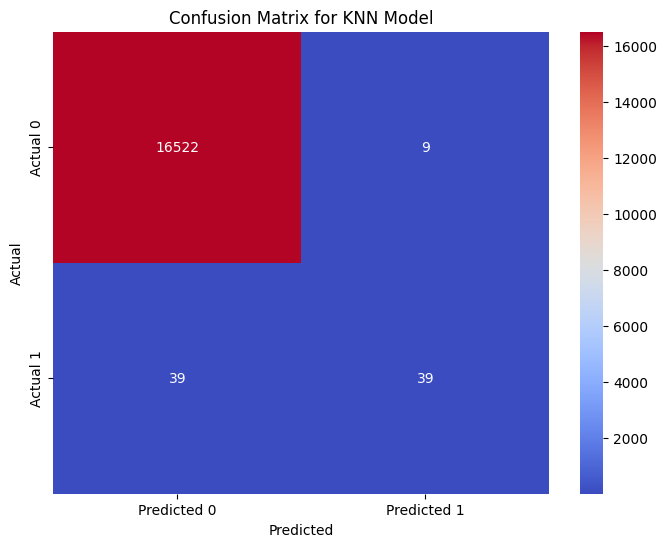

In [52]:
knn_model_output(x_train, y_train, x_test, y_test)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


c:\Users\w11\anaconda3\envs\deepLearning\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Params: {'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 1}
Best Recall Score: 0.771255060728745


c:\Users\w11\anaconda3\envs\deepLearning\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:56:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGB Best Model Recall: 0.782051282051282
XGB Log Loss: 0.05078020241990064
XGB Confusion Matrix: 

 [[16531     0]
 [   17    61]]


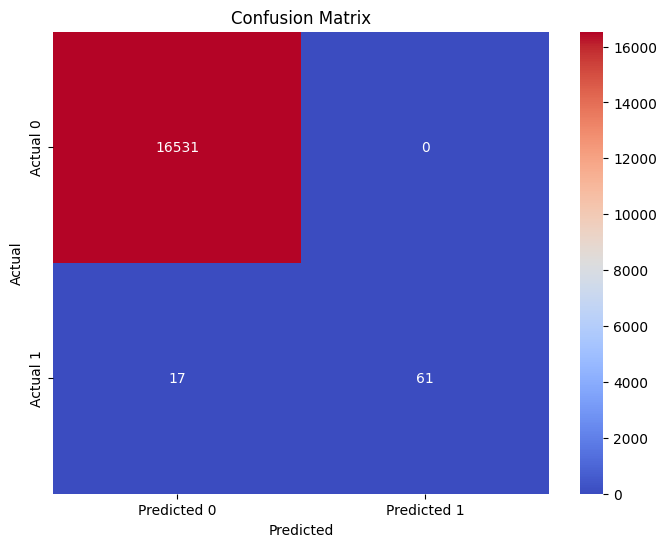

In [53]:
xgb_model_output(x_train, y_train, x_test, y_test)

Fitting 5 folds for each of 138 candidates, totalling 690 fits


c:\Users\w11\anaconda3\envs\deepLearning\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
60 fits failed out of a total of 690.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\w11\anaconda3\envs\deepLearning\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\w11\anaconda3\envs\deepLearning\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\w11\anaconda3\envs\deepLearning\Lib\site-packages\skl

Best Params: {'logistic__C': 1, 'logistic__max_iter': 500, 'logistic__penalty': 'l1', 'logistic__solver': 'saga'}
Best Recall Score: 0.7043184885290149
Logistic Regression Best Model Recall: 0.7051282051282052
Logistic Regression Best Model Log Loss: 0.008893225563690921


c:\Users\w11\anaconda3\envs\deepLearning\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


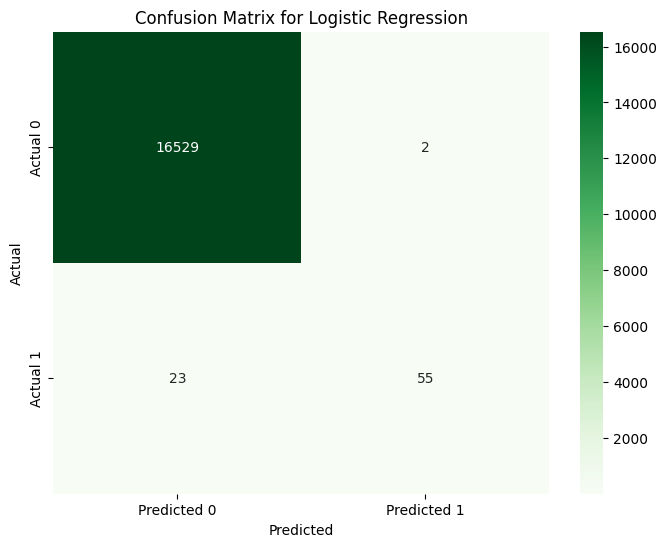

In [54]:
logistic_regression_model_output(x_train, y_train, x_test, y_test)

Fitting 5 folds for each of 720 candidates, totalling 3600 fits
Best Params: {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 50}
Best Recall Score: 0.771255060728745
Random Forest Best Model Recall: 0.7564102564102564
Random Forest Log Loss: 0.008955707885078573


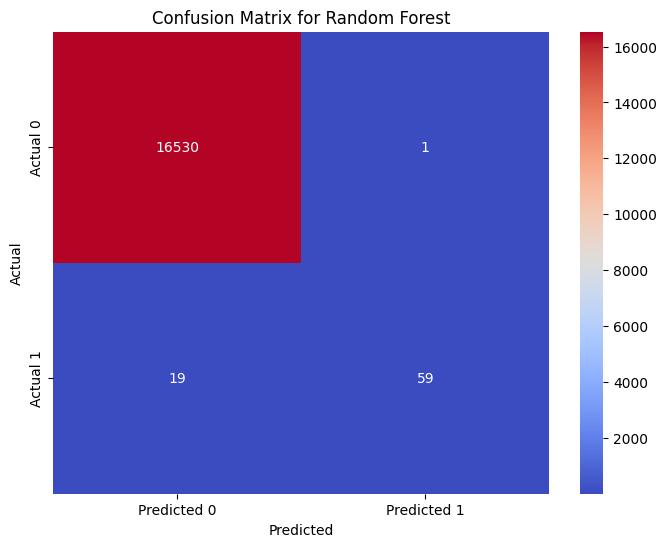

In [55]:
rf_model_output(x_train, y_train, x_test, y_test)

In [56]:
##svm_model_output(x_train, y_train, x_test, y_test)

c:\Users\w11\anaconda3\envs\deepLearning\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
520/520 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step  
 - val_recall: 0.5128
1212/1212 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9410 - loss: 0.1305 - val_accuracy: 0.9975 - val_loss: 0.0125 - val_recall: 0.5128
Epoch 2/100
520/520 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step   -
 - val_recall: 0.6282
1212/1212 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9976 - loss: 0.0113 - val_accuracy: 0.9981 - val_loss: 0.0121 - val_recall: 0.6282
Epoch 3/100
520/520 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
 - val_recall: 0.7308
1212/1212 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.9979 - loss: 0.0083 - val_accuracy: 0.9967 - val_loss: 0.0146 - val_recall: 0.7308
Epoch 4/100
520/520 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step   - acc
 - val_recall: 0.4744
1212/1212 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.9981 - loss: 0.0070 - val_accuracy: 0.9975 - val_loss: 0.0128 - val_recall: 0.4744
Epoch 5/100
520/520 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step   - accur
 - val_recall: 0.6282
1212/1212 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/ste

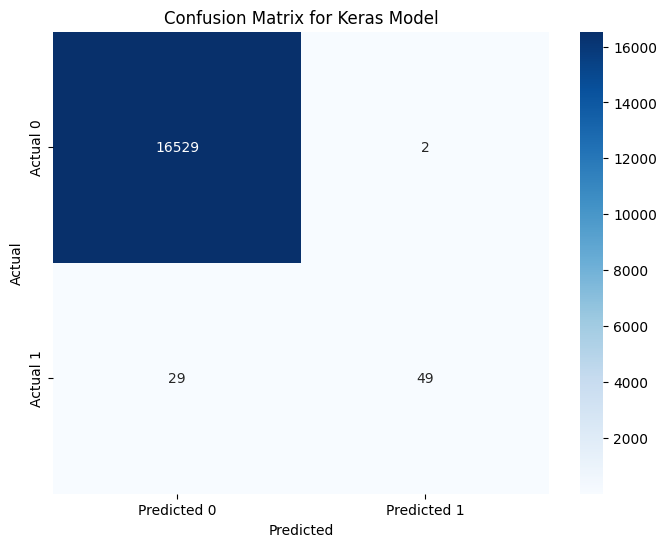

In [57]:
keras_model_output(x_train, y_train, x_test, y_test)

## Train Data with average of string features

In [58]:
country_filtered = pd.merge(country_filtered,mean_dim,
                            on = ['medium','mobile_brand_name','country','category'],
                            how = 'left',
                            suffixes = ('','_mean'))
country_filtered = pd.merge(country_filtered, mean_medium, on='medium', how='left', suffixes=('', '_mean_medium'))
country_filtered = pd.merge(country_filtered, mean_mobile_brand_name, on='mobile_brand_name', how='left', suffixes=('', '_mean_mobile_brand'))
country_filtered = pd.merge(country_filtered, mean_country, on='country', how='left', suffixes=('', '_mean_country'))
country_filtered = pd.merge(country_filtered, mean_category, on='category', how='left', suffixes=('', '_mean_category'))
country_filtered.columns = [col.replace('itemRevenue90_', 'taget_') if 'itemRevenue90_' in col else col for col in country_filtered.columns]
country_filtered.head(9)

,user_pseudo_id,medium,mobile_brand_name,country,category,cnt,fdate,sessionCnt,sessionDate,itemBrandCount,...,gdp_2020_value,gdp_2021_value,Avg_gdp,powerUSer,LogGDP,taget_mean,taget_mean_medium,taget_mean_mobile_brand,taget_mean_country,taget_mean_category
0,1010112.7141184805,<Other>,Apple,India,mobile,1,2020-11-11,1,1,0,...,1915.552,2250.179,2082.8655,0,7.641500,1.558333,1.537019,1.580560,1.671229,1.773877
1,10294207.4077107086,(none),Google,United States,desktop,1,2020-11-03,1,1,0,...,64367.435,70995.794,67681.6145,0,11.122570,1.437526,1.658240,1.865692,1.748890,1.686789
2,1042028.8380668615,organic,Apple,Canada,mobile,1,2020-11-06,1,1,0,...,43573.195,52520.512,48046.8535,0,10.779932,2.707589,1.791319,1.580560,1.728493,1.773877
3,10712558.3009819088,organic,Google,United States,desktop,1,2020-11-10,2,2,2,...,64367.435,70995.794,67681.6145,0,11.122570,1.691988,1.791319,1.865692,1.748890,1.686789
4,1112372.0306952708,(none),Huawei,United States,mobile,1,2020-11-07,1,1,0,...,64367.435,70995.794,67681.6145,0,11.122570,0.819048,1.658240,2.465035,1.748890,1.773877
5,11154046.5845154271,(none),Google,South Korea,mobile,1,2020-11-18,3,3,2,...,31728.306,35125.524,33426.9150,0,10.417117,0.000000,1.658240,1.865692,1.556330,1.773877
6,11426844.4706342307,organic,Huawei,India,mobile,1,2020-11-03,2,1,0,...,1915.552,2250.179,2082.8655,0,7.641500,1.365854,1.791319,2.465035,1.671229,1.773877
7,1172130381.6818952078,referral,Google,United States,desktop,1,2020-11-16,1,1,1,...,64367.435,70995.794,67681.6145,0,11.122570,2.789860,1.800359,1.865692,1.748890,1.686789
8,1178795.1133493018,(none),Google,United States,desktop,1,2020-11-06,1,1,0,...,64367.435,70995.794,67681.6145,0,11.122570,1.437526,1.658240,1.865692,1.748890,1.686789


In [59]:
country_filtered[(country_filtered['medium'] == '(data deleted)') & (country_filtered['mobile_brand_name'] == 'Apple') & (country_filtered['country'] == 'United States') &
(country_filtered['category'] == 'desktop')]

,user_pseudo_id,medium,mobile_brand_name,country,category,cnt,fdate,sessionCnt,sessionDate,itemBrandCount,...,gdp_2020_value,gdp_2021_value,Avg_gdp,powerUSer,LogGDP,taget_mean,taget_mean_medium,taget_mean_mobile_brand,taget_mean_country,taget_mean_category
22303,72247217.2012519479,(data deleted),Apple,United States,desktop,1,2020-11-04,2,1,0,...,64367.435,70995.794,67681.6145,0,11.12257,18.666667,9.47619,1.58056,1.74889,1.686789
50620,61663331.5187574428,(data deleted),Apple,United States,desktop,1,2020-11-13,1,1,3,...,64367.435,70995.794,67681.6145,0,11.12257,18.666667,9.47619,1.58056,1.74889,1.686789
53071,82865714.7704602382,(data deleted),Apple,United States,desktop,1,2020-11-13,3,2,2,...,64367.435,70995.794,67681.6145,0,11.12257,18.666667,9.47619,1.58056,1.74889,1.686789


In [60]:
country_filtered[(country_filtered['medium'] == 'cpc') & (country_filtered['mobile_brand_name'] == 'Apple') & (country_filtered['country'] == 'United States') &
(country_filtered['category'] == 'desktop')].head()

,user_pseudo_id,medium,mobile_brand_name,country,category,cnt,fdate,sessionCnt,sessionDate,itemBrandCount,...,gdp_2020_value,gdp_2021_value,Avg_gdp,powerUSer,LogGDP,taget_mean,taget_mean_medium,taget_mean_mobile_brand,taget_mean_country,taget_mean_category
292,5284377.8884147813,cpc,Apple,United States,desktop,1,2020-11-18,2,1,2,...,64367.435,70995.794,67681.6145,0,11.12257,1.00565,1.969041,1.58056,1.74889,1.686789
511,8409718.6570217329,cpc,Apple,United States,desktop,1,2020-11-03,2,1,1,...,64367.435,70995.794,67681.6145,0,11.12257,1.00565,1.969041,1.58056,1.74889,1.686789
523,85203732.1010775869,cpc,Apple,United States,desktop,1,2020-11-06,1,1,0,...,64367.435,70995.794,67681.6145,0,11.12257,1.00565,1.969041,1.58056,1.74889,1.686789
616,18583161.2813390975,cpc,Apple,United States,desktop,1,2020-11-15,1,1,1,...,64367.435,70995.794,67681.6145,0,11.12257,1.00565,1.969041,1.58056,1.74889,1.686789
682,27631913.1045119176,cpc,Apple,United States,desktop,1,2020-11-11,1,1,1,...,64367.435,70995.794,67681.6145,0,11.12257,1.00565,1.969041,1.58056,1.74889,1.686789


In [61]:
country_filtered['powerUSer'].value_counts(normalize  = True)

powerUSer
0    0.995123
1    0.004877
Name: proportion, dtype: float64

In [62]:
pd.set_option("display.max_columns",None)
country_filtered.head()

,user_pseudo_id,medium,mobile_brand_name,country,category,cnt,fdate,sessionCnt,sessionDate,itemBrandCount,itemCatCount,viwePromotion,SelectPromotion,itemViewCnt,itemSelectCnt,paymetInfoAdd,shippingInfoAdd,ScrollpageLocationCnt,ScrollpageTitleCnt,pageViewPageLocationCnt,pageViewPageTitleCnt,itemViews,addToCarts,addToItemId,searchResultViewedCnt,checkOut,ecommercePurchases,purchaseToViewRate,itemPurchaseName,itemPurchaseQuantity,itemRevenue15,itemRevenue2,itemRevenue90,gdp_2020_value,gdp_2021_value,Avg_gdp,powerUSer,LogGDP,taget_mean,taget_mean_medium,taget_mean_mobile_brand,taget_mean_country,taget_mean_category
0,1010112.7141184805,<Other>,Apple,India,mobile,1,2020-11-11,1,1,0,0,0,0,0,0,0,0,0,0,4,4,0,0,0,0,0,0,0.0,0,0,0.0,0.0,0.0,1915.552,2250.179,2082.8655,0,7.641500,1.558333,1.537019,1.580560,1.671229,1.773877
1,10294207.4077107086,(none),Google,United States,desktop,1,2020-11-03,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0.0,0,0,0.0,0.0,0.0,64367.435,70995.794,67681.6145,0,11.122570,1.437526,1.658240,1.865692,1.748890,1.686789
2,1042028.8380668615,organic,Apple,Canada,mobile,1,2020-11-06,1,1,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0.0,0,0,0.0,0.0,0.0,43573.195,52520.512,48046.8535,0,10.779932,2.707589,1.791319,1.580560,1.728493,1.773877
3,10712558.3009819088,organic,Google,United States,desktop,1,2020-11-10,2,2,2,2,1,0,12,0,0,0,2,2,5,5,2,0,0,0,0,0,0.0,0,0,0.0,0.0,0.0,64367.435,70995.794,67681.6145,0,11.122570,1.691988,1.791319,1.865692,1.748890,1.686789
4,1112372.0306952708,(none),Huawei,United States,mobile,1,2020-11-07,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0.0,0,0,0.0,0.0,0.0,64367.435,70995.794,67681.6145,0,11.122570,0.819048,1.658240,2.465035,1.748890,1.773877


In [63]:
x = country_filtered.drop(['user_pseudo_id','itemRevenue90','itemRevenue2','medium','mobile_brand_name','country','category','cnt','fdate','powerUSer'], axis = 1)
y = country_filtered.powerUSer

In [64]:
x.head()

,sessionCnt,sessionDate,itemBrandCount,itemCatCount,viwePromotion,SelectPromotion,itemViewCnt,itemSelectCnt,paymetInfoAdd,shippingInfoAdd,ScrollpageLocationCnt,ScrollpageTitleCnt,pageViewPageLocationCnt,pageViewPageTitleCnt,itemViews,addToCarts,addToItemId,searchResultViewedCnt,checkOut,ecommercePurchases,purchaseToViewRate,itemPurchaseName,itemPurchaseQuantity,itemRevenue15,gdp_2020_value,gdp_2021_value,Avg_gdp,LogGDP,taget_mean,taget_mean_medium,taget_mean_mobile_brand,taget_mean_country,taget_mean_category
0,1,1,0,0,0,0,0,0,0,0,0,0,4,4,0,0,0,0,0,0,0.0,0,0,0.0,1915.552,2250.179,2082.8655,7.641500,1.558333,1.537019,1.580560,1.671229,1.773877
1,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0.0,0,0,0.0,64367.435,70995.794,67681.6145,11.122570,1.437526,1.658240,1.865692,1.748890,1.686789
2,1,1,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0.0,0,0,0.0,43573.195,52520.512,48046.8535,10.779932,2.707589,1.791319,1.580560,1.728493,1.773877
3,2,2,2,2,1,0,12,0,0,0,2,2,5,5,2,0,0,0,0,0,0.0,0,0,0.0,64367.435,70995.794,67681.6145,11.122570,1.691988,1.791319,1.865692,1.748890,1.686789
4,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0.0,0,0,0.0,64367.435,70995.794,67681.6145,11.122570,0.819048,1.658240,2.465035,1.748890,1.773877


In [65]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: powerUSer, dtype: int64

In [66]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.30, random_state = 42)

In [67]:
x_train.shape

(38754, 33)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
Best Params: {'knn__metric': 'euclidean', 'knn__n_neighbors': np.int64(1), 'knn__weights': 'uniform'}
Best Recall Score: 0.5421052631578948
KNN Best Model Recall: 0.5
KNN Best Model Precision: 0.6610169491525424
KNN Best Model Accuracy: 0.996447709073394
KNN Best Model Log Loss: 0.12803754289589472


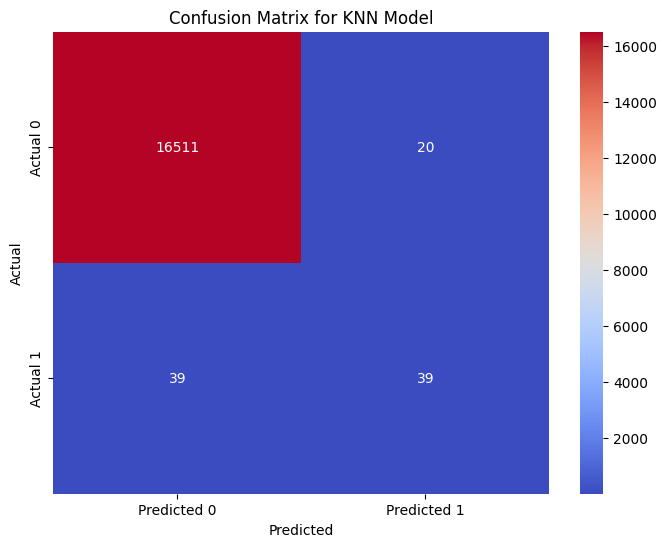

In [68]:
knn_model_output(x_train, y_train, x_test, y_test)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


c:\Users\w11\anaconda3\envs\deepLearning\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Params: {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 150, 'reg_alpha': 0, 'reg_lambda': 2}
Best Recall Score: 0.7817813765182187


c:\Users\w11\anaconda3\envs\deepLearning\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:46:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGB Best Model Recall: 0.782051282051282
XGB Log Loss: 0.007691894233735487
XGB Confusion Matrix: 

 [[16530     1]
 [   17    61]]


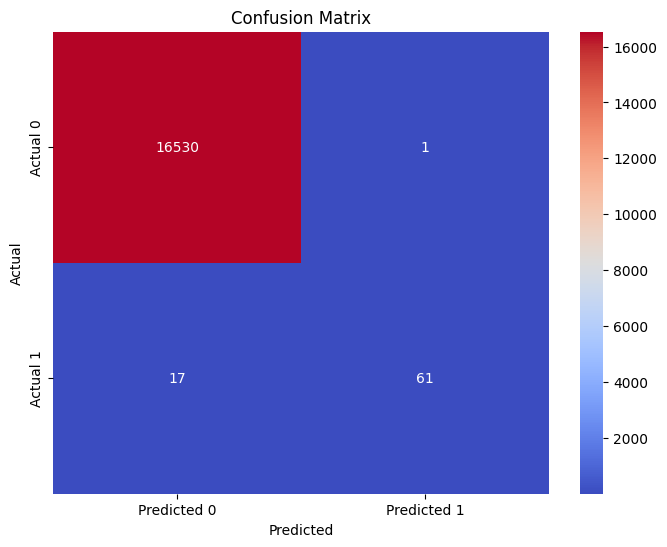

In [69]:
xgb_model_output(x_train, y_train, x_test, y_test)

In [70]:
##logistic_regression_model_output(x_train, y_train, x_test, y_test)

In [71]:
##rf_model_output(x_train, y_train, x_test, y_test)

In [72]:
##svm_model_output(x_train, y_train, x_test, y_test)

In [73]:
##keras_model_output(x_train, y_train, x_test, y_test)

In [74]:
ros = RandomOverSampler()
x_resambled , y_resambled = ros.fit_resample(x_train,y_train)


x_trainf_float = x_train.astype('float64')
smote = SMOTE(k_neighbors=10)  # En düşük değer
x_smoted, y_smoted = smote.fit_resample(x_trainf_float, y_train)

adasyn = ADASYN()
x_adasyn, y_adasyn = adasyn.fit_resample(x_trainf_float, y_train)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
Best Params: {'knn__metric': 'euclidean', 'knn__n_neighbors': np.int64(19), 'knn__weights': 'uniform'}
Best Recall Score: 0.9887972218321925
KNN Best Model Recall: 0.7051282051282052
KNN Best Model Precision: 0.20446096654275092
KNN Best Model Accuracy: 0.9857306279727859
KNN Best Model Log Loss: 0.11652897519272096


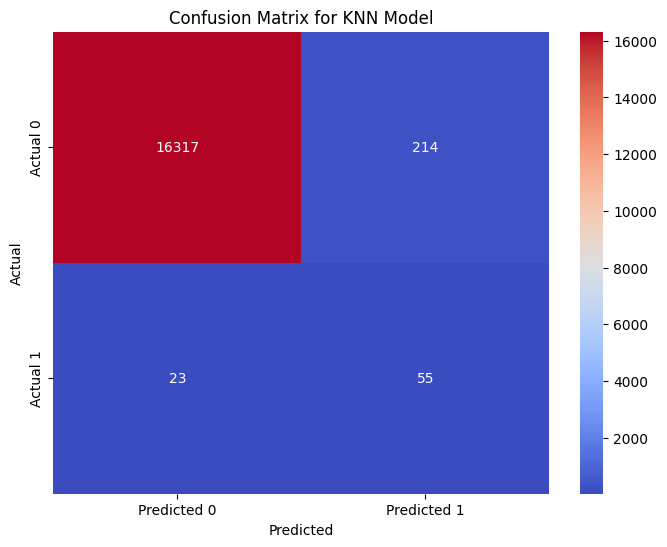

In [75]:
knn_model_output(x_resambled , y_resambled , x_test, y_test) 

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


c:\Users\w11\anaconda3\envs\deepLearning\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Params: {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 1}
Best Recall Score: 1.0


c:\Users\w11\anaconda3\envs\deepLearning\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:20:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGB Best Model Recall: 0.782051282051282
XGB Log Loss: 0.026231473187829472
XGB Confusion Matrix: 

 [[16442    89]
 [   17    61]]


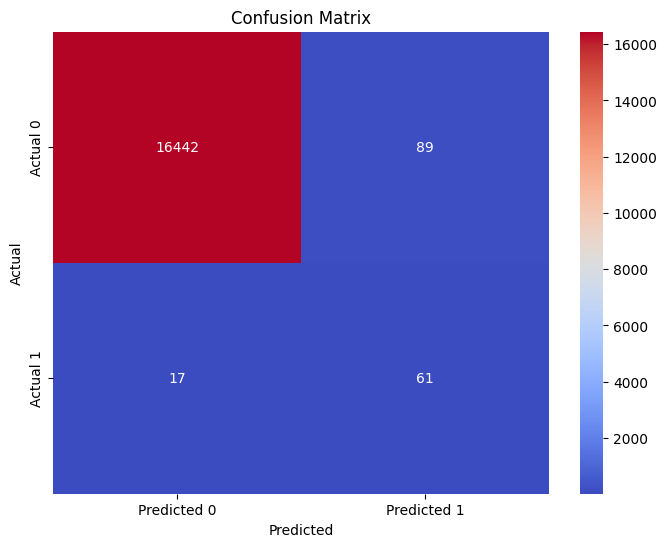

In [76]:
xgb_model_output(x_resambled , y_resambled , x_test, y_test)

Fitting 5 folds for each of 138 candidates, totalling 690 fits


c:\Users\w11\anaconda3\envs\deepLearning\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
60 fits failed out of a total of 690.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\w11\anaconda3\envs\deepLearning\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\w11\anaconda3\envs\deepLearning\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\w11\anaconda3\envs\deepLearning\Lib\site-packages\skl

Best Params: {'logistic__C': 0.1, 'logistic__max_iter': 100, 'logistic__penalty': 'l1', 'logistic__solver': 'liblinear'}
Best Recall Score: 0.9001348325804417
Logistic Regression Best Model Recall: 0.8076923076923077
Logistic Regression Best Model Log Loss: 0.13868977587043985


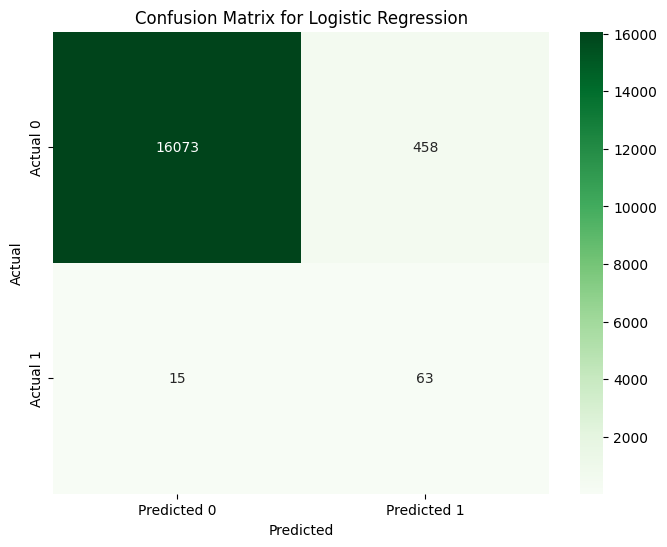

In [77]:
logistic_regression_model_output(x_resambled , y_resambled , x_test, y_test)

Fitting 5 folds for each of 720 candidates, totalling 3600 fits
Best Params: {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
Best Recall Score: 1.0
Random Forest Best Model Recall: 0.6923076923076923
Random Forest Log Loss: 0.03823294547136699


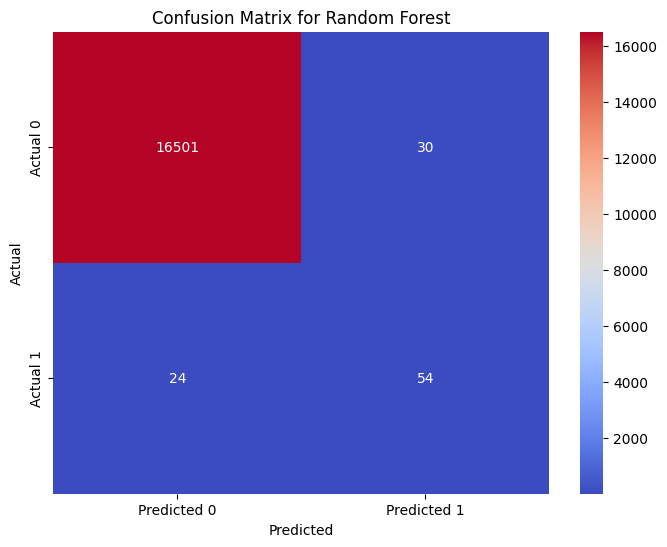

In [78]:
rf_model_output(x_resambled , y_resambled , x_test, y_test)

In [79]:
##svm_model_output(x_resambled , y_resambled , x_test, y_test)

In [80]:
##keras_model_output(x_resambled , y_resambled , x_test, y_test)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
Best Params: {'knn__metric': 'euclidean', 'knn__n_neighbors': np.int64(1), 'knn__weights': 'uniform'}
Best Recall Score: 0.9997666042350227
KNN Best Model Recall: 0.5897435897435898
KNN Best Model Precision: 0.2787878787878788
KNN Best Model Accuracy: 0.9909085435607201
KNN Best Model Log Loss: 0.3276893046996624


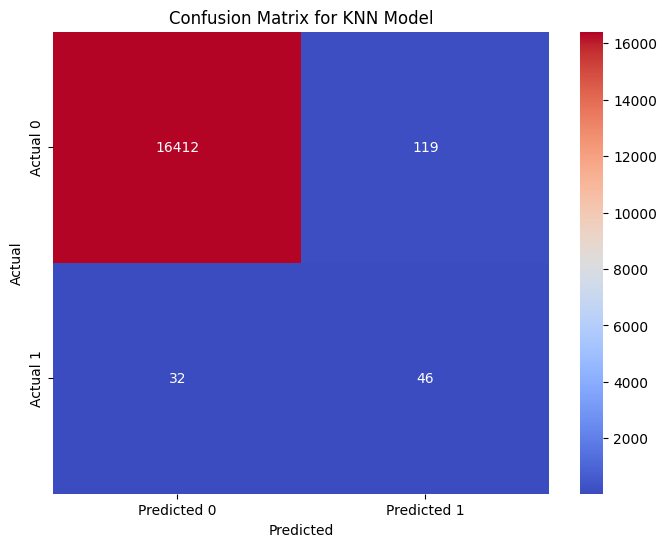

In [81]:
knn_model_output(x_smoted, y_smoted , x_test, y_test)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


c:\Users\w11\anaconda3\envs\deepLearning\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Params: {'gamma': 0, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 1}
Best Recall Score: 0.9991960681782602


c:\Users\w11\anaconda3\envs\deepLearning\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:02:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGB Best Model Recall: 0.782051282051282
XGB Log Loss: 0.009433189899796834
XGB Confusion Matrix: 

 [[16526     5]
 [   17    61]]


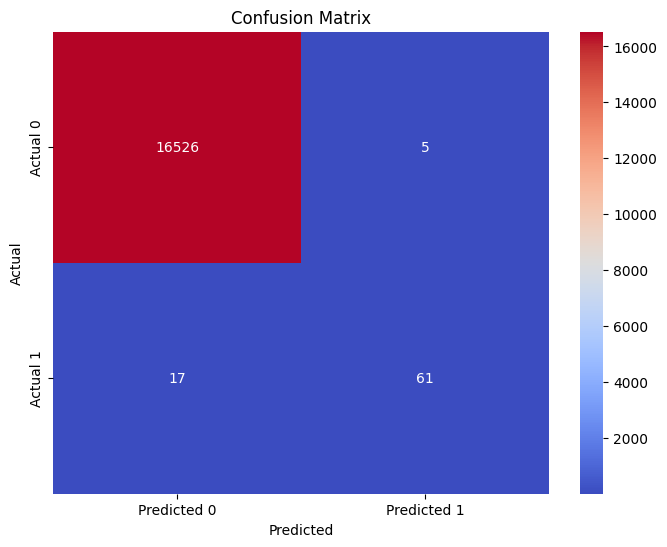

In [82]:
xgb_model_output(x_smoted, y_smoted , x_test, y_test)

logistic_regression_model_output(x_smoted, y_smoted , x_test, y_test)

In [83]:
##svm_model_output(x_smoted, y_smoted , x_test, y_test)

keras_model_output(x_smoted, y_smoted , x_test, y_test)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
Best Params: {'knn__metric': 'manhattan', 'knn__n_neighbors': np.int64(21), 'knn__weights': 'distance'}
Best Recall Score: 0.9824411501110394
KNN Best Model Recall: 0.7435897435897436
KNN Best Model Precision: 0.19205298013245034
KNN Best Model Accuracy: 0.9841050033114577
KNN Best Model Log Loss: 0.13007838834946633


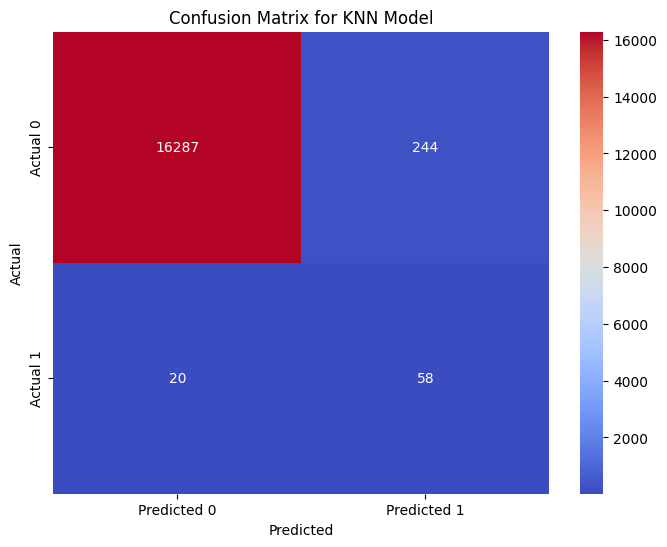

In [84]:
knn_model_output(x_adasyn, y_adasyn , x_test, y_test)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best Params: {'gamma': 0, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 150, 'reg_alpha': 0.1, 'reg_lambda': 1}
Best Recall Score: 0.9982622362513863


c:\Users\w11\anaconda3\envs\deepLearning\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:40:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGB Best Model Recall: 0.782051282051282
XGB Log Loss: 0.010618902674341828
XGB Confusion Matrix: 

 [[16525     6]
 [   17    61]]


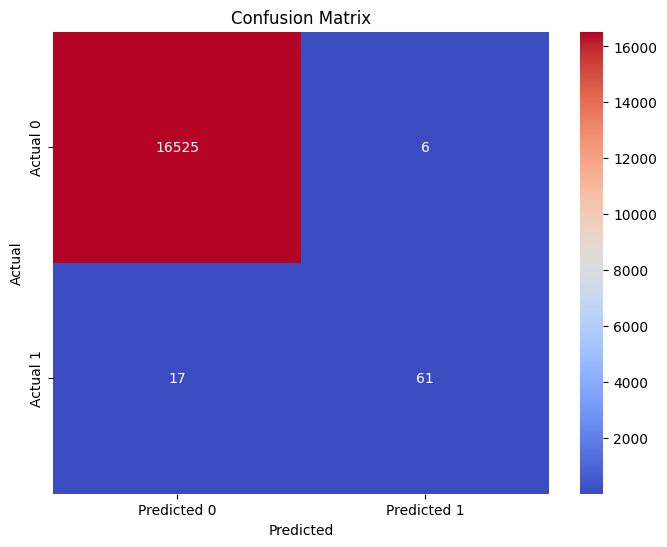

In [85]:
xgb_model_output(x_adasyn, y_adasyn , x_test, y_test)

logistic_regression_model_output(x_adasyn, y_adasyn , x_test, y_test)

In [86]:
##svm_model_output(x_adasyn, y_adasyn , x_test, y_test)

keras_model_output(x_adasyn, y_adasyn , x_test, y_test)

In [87]:

import plotly.io as pio
pio.renderers.default = "browser"

# Sayısal ve string sütunları ayrı ayrı seçiyoruz
numeric_features = merged_df.select_dtypes(include=['number']).columns.tolist()
string_features = merged_df.select_dtypes(include=['object', 'string']).columns.tolist()

# powerUSer ve itemRevenue90'ı sayısal sütunlardan çıkarıyoruz
numeric_features = [col for col in numeric_features if col not in ['powerUSer', 'user_pseudo_id']]

# Varsayılan olarak hiçbir şey seçilmemiş olacak
default_feature = None

# Ortalamaları hesaplama fonksiyonu
def calculate_means(df, feature):
    return df.groupby('powerUSer')[feature].mean().reset_index()

# Grafik oluşturma
fig = go.Figure()

# Dropdown menüsü (default olarak boş gelir)
fig.update_layout(
    updatemenus=[
        dict(
            buttons=[
                dict(
                    label="None",
                    method="update",
                    args=[{"visible": [False]}, {"title": "Select a Feature to Display"}]
                )
            ] + [
                dict(
                    label=feature,
                    method="update",
                    args=[
                        {
                            "y": [calculate_means(merged_df, feature)[feature]],
                            "x": [calculate_means(merged_df, feature)['powerUSer'].astype(str)],
                            "visible": [True]
                        },
                        {"title": f"Power USer Mean Values for {feature}"}
                    ]
                ) for feature in numeric_features
            ],
            direction="down",
            showactive=True,
        )
    ]
)

fig.add_trace(go.Bar(
    x=[],  
    y=[],
    name="Empty"
))

fig.update_layout(
    title="Select a Feature to Display",
    xaxis_title="Power USer (0 or 1)",
    yaxis_title="Mean Value",
    legend_title="Feature",
)

fig.show()

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best Params: {'gamma': 0, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 150, 'reg_alpha': 0.1, 'reg_lambda': 1}
Best Recall Score: 0.9982622362513863


c:\Users\w11\anaconda3\envs\deepLearning\Lib\site-packages\xgboost\core.py:158: UserWarning:

[14:55:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




XGB Best Model Recall: 0.782051282051282
XGB Log Loss: 0.00901309377801519
XGB Confusion Matrix: 

 [[16530     1]
 [   17    61]]


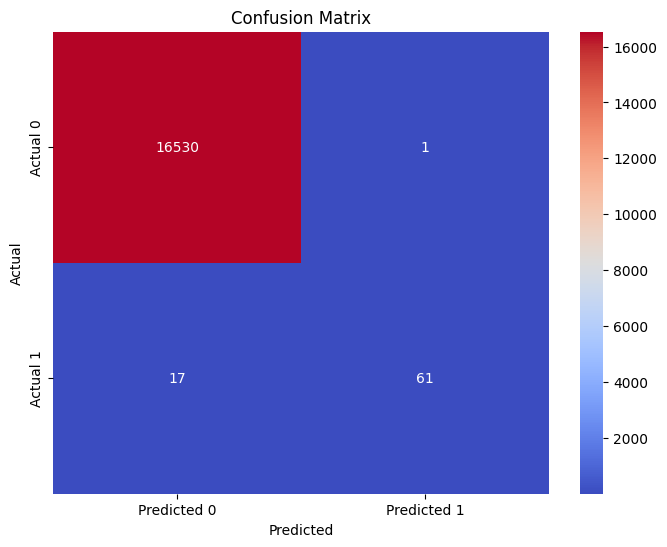

In [89]:

param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [1, 2]
}

xgb = XGBClassifier( eval_metric='logloss')
grid_search = GridSearchCV(xgb, param_grid, cv=5, scoring='recall', verbose=1)

# Fit GridSearchCV Model
grid_search.fit(x_adasyn, y_adasyn)

# Best Recall Score and Parameters
print("Best Params:", grid_search.best_params_)
print("Best Recall Score:", grid_search.best_score_)

# Retrain model with best parameters on the entire training data
best_params = grid_search.best_params_
xgb_best_adasyn = XGBClassifier(**best_params, use_label_encoder=False, eval_metric='logloss')
xgb_best_adasyn.fit(x_train, y_train)


# Predict for test using the best model
y_pred_xgb_best_adsyn = xgb_best_adasyn.predict(x_test)
y_prob_xgb_best_adsyn = xgb_best_adasyn.predict_proba(x_test)
recall_xgb_best_adsyn = recall_score(y_test, y_pred_xgb_best_adsyn)
LogLoss_xgb_best_adsyn = log_loss(y_test, y_prob_xgb_best_adsyn)
print(f'XGB Best Model Recall: {recall_xgb_best_adsyn}')
print(f'XGB Log Loss: {LogLoss_xgb_best_adsyn}')
print('XGB Confusion Matrix: \n\n', confusion_matrix(y_test, y_pred_xgb_best_adsyn))

# Displaying Confusion Matrix
cm = confusion_matrix(y_test, y_pred_xgb_best_adsyn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='coolwarm', xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

<Figure size 1800x800 with 0 Axes>

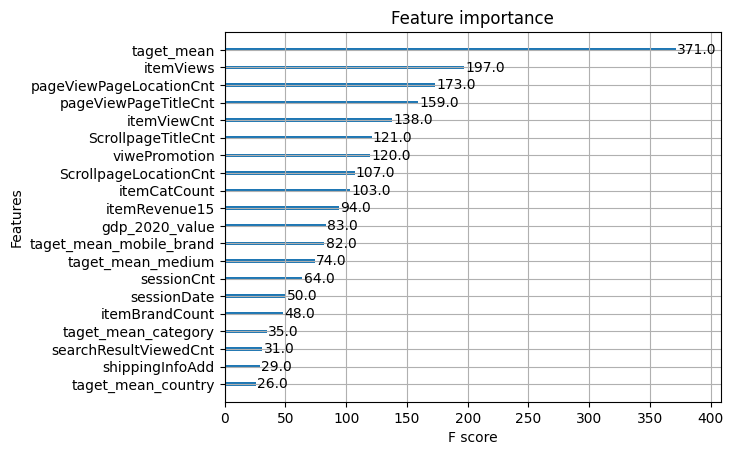

In [98]:
plt.figure(figsize= (18,8))
xgb.plot_importance(xgb_best_adasyn, max_num_features =20)
plt.show()

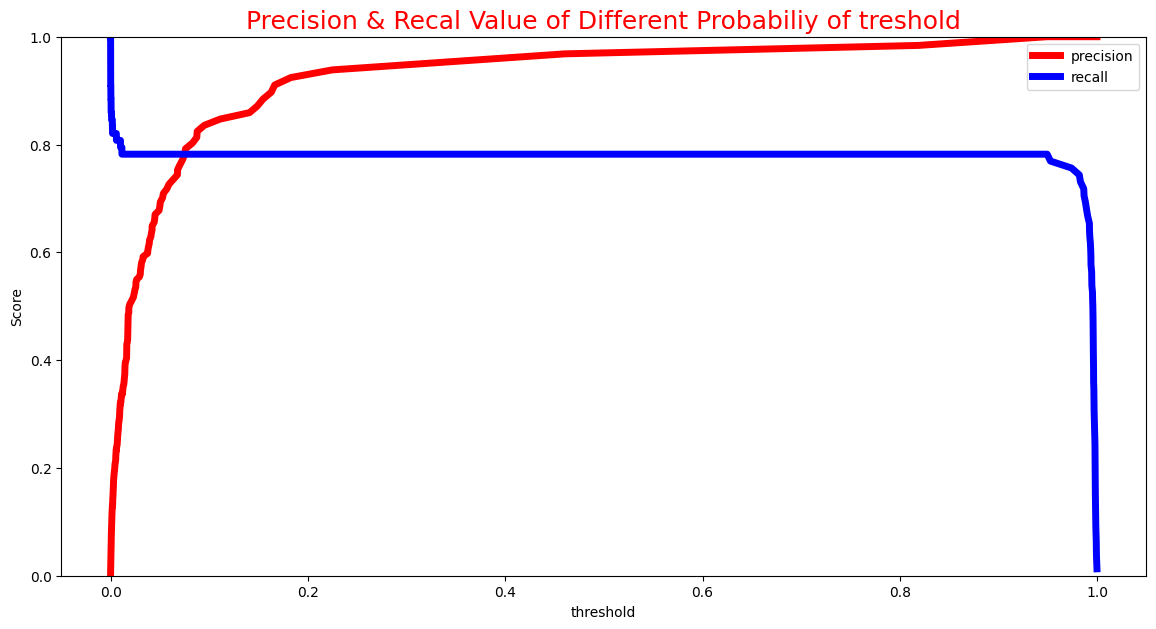

In [99]:
y_scores = xgb_best_adasyn.predict_proba(x_test)
y_scores = y_scores[:,1]

precision, recall, threshold = precision_recall_curve(y_test, y_scores)
def plot_precision_and_recall(precision, recall, threshold):
    plt.plot(threshold, precision[:-1], "r-", label="precision", linewidth=5)
    plt.plot(threshold, recall[:-1], "b", label="recall", linewidth=5)
    plt.xlabel("threshold", fontsize=10)
    plt.ylabel('Score', fontsize = 10)
    plt.legend(loc="upper right", fontsize=10)
    plt.ylim([0, 1])
    plt.title('Precision & Recal Value of Different Probabiliy of treshold', fontsize = 18, c = 'r')

plt.figure(figsize=[14, 7])
plot_precision_and_recall(precision, recall, threshold)

In [100]:
dump(xgb_best_adasyn, 'xgb_best_adasyn.pkl')


['xgb_best_adasyn.pkl']

In [101]:
from sklearn.decomposition import PCA

# 10 bileşene indir
pca = PCA(n_components=10)
x_pca = pca.fit_transform(x)

In [103]:
x_train_pca, x_test, y_train, y_test = train_test_split(x_pca, y ,test_size = 0.20, random_state = 42)

In [104]:
x_trainf_pca_float = x_train_pca.astype('float64')
x_adasyn_pca, y_adasyn = adasyn.fit_resample(x_trainf_pca_float, y_train)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


c:\Users\w11\anaconda3\envs\deepLearning\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning:

invalid value encountered in cast



Best Params: {'gamma': 0.2, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 50, 'reg_alpha': 0, 'reg_lambda': 2}
Best Recall Score: 0.913088218713557
XGB Best Model Recall: 0.7659574468085106
XGB Log Loss: 0.09115213909593994
XGB Confusion Matrix: 

 [[10691   335]
 [   11    36]]


c:\Users\w11\anaconda3\envs\deepLearning\Lib\site-packages\xgboost\core.py:158: UserWarning:

[15:15:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




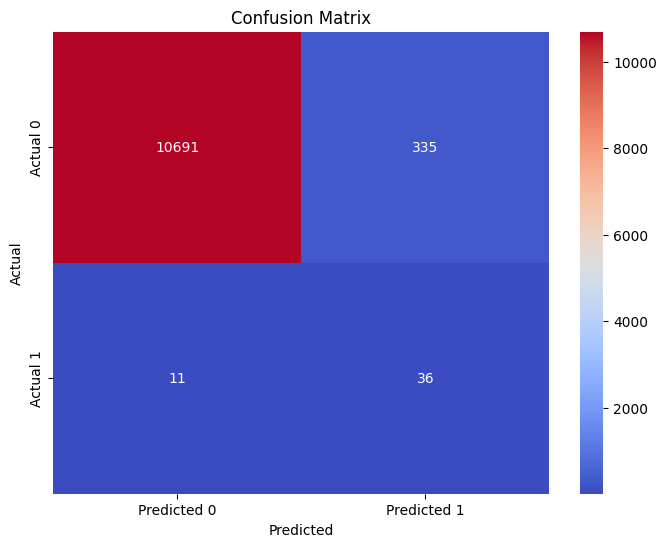

In [105]:
xgb_model_output(x_adasyn_pca,y_adasyn,x_test, y_test)

In [110]:
print("Özellik sayısı:", x.shape[1])
print("Sınıf sayısı:", len(set(y)))


Özellik sayısı: 33
Sınıf sayısı: 2


In [109]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# LDA modelini oluşturun
lda = LDA(n_components=12)

# LDA modelini fit ve transform işlemi
x_lda = lda.fit_transform(x, y)



ValueError: n_components cannot be larger than min(n_features, n_classes - 1).

In [ ]:
x_train_lda, x_test, y_train, y_test = train_test_split(x_lda, y ,test_size = 0.20, random_state = 42)

In [ ]:
x_trainf_lda_float = x_train_lda.astype('float64')
x_adasyn_lda, y_adasyn = adasyn.fit_resample(x_trainf_lda_float, y_train)

In [ ]:
xgb_model_output(x_adasyn_lda,y_adasyn,x_test, y_test)